### Install
1. `conda create --name fall  python=3.9`
2. `conda activate fall`
3. `pip install -r requirements.txt`
##### Ubuntu
4. `conda install -c pytorch faiss-cpu=1.7.4 mkl=2021 blas=1.0=mkl`
##### windows  
4. `conda install -c conda-forge faiss`

(using the other conda channel in Windows causes missing dlls)

### Introduction: Medical Narrative Mining

The objective of this compitition is to mine the narrative field of medical records to reveal insights into old age(65+) falls.
The tabular data provided, are extracted from the National Electronic Injury Surveillance System (NEISS) and contains key features such as age, sex, race, date, location, product involved, body_part, diagnosis and disposition. However precipitating activity is absent. This feature along with some other possibly useful atrribute are to be extracted and analysed from the narratives(400 max charecter) for insights.

To facilitate mining the narrative field we first dig into the NEISS coding manual which sets rules and guidelines for how the narrative filed is to be written. For us the most relevant aspect is the guideline to:
"Describe the sequence of events, alcohol/drug involvement, and the affected body part(s) in the middle of the comment" and "relevant clinician’s diagnoses should be at the end of the comment". The sequence of event implies precipitating event to be in the first sentence. So ideally if three sentences are given in sequences we can expect the precipitating event to be on the first sentence but this is seldom the case. However the word "And" or "&" is used often as event seperator and this we can use. According to the manual 's/p' and 'after' are mentioned explicitly to be used as event seperator which also we use. 

Keyword "Slipped and Fell" and "Tripped and Fell" along with their abbreviation "s'd&f" and "t'd&f" are explicitly mentioned in the manual to be used in describing the said event. These are found with high frequency in the narratives( as will be shown) and could be directly searched for their occurences using keyword search. Besides these, there are other activity or event such as walking or getting up that causes a fall. Only doing keyword search is inefficient and could lead to wrong distribution.

So We apply semantic search using FAISS (Facebook AI Similarity Search) for querying our vector store(embeddings of all narratives in primary.csv computed via OpenAI’s text-embedding-ada-002 model and provided by competition host). How we formulate the query and group our activity class(precipitating event) requires carefull consideration, given the dataset(with already extracted attrubutes) and how the narrative is structured.

First We will load our data along with narrative embedding to FAISS. As we will be performing 'range search', we will also be using only the 'cpu' as 'gpu' is unsupported for this operation.

Given a query, 'Range Search' returns all instances in the vector store below a threshold computed using a distance metric between the query embedding and value embedding in the vector store.


In [1]:
# Major imports
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import json
from tqdm import tqdm
import os
import time
import faiss
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import openTSNE
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, ndcg_score, davies_bouldin_score
from langchain.embeddings import OpenAIEmbeddings
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", rc={'figure.figsize':(16, 8)})
import networkx as nx
from yfiles_jupyter_graphs import GraphWidget
from typing import Dict
import gc
import warnings
warnings.filterwarnings("ignore")
np.random.seed(13)

tqdm.pandas()
from IPython.display import clear_output

In [2]:
# nltk downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Our dataset, set path according to your folder and file structure
DATA_DIR = Path.cwd().parent / "data"

primary_path = DATA_DIR / 'raw/primary_data.csv'
variable_mapping = DATA_DIR / 'raw/variable_mapping.json'
embedding_path = DATA_DIR / 'raw/openai_embeddings_primary_narratives.parquet.gzip'

<span style='color:red'>YOU MUST SET AN OPENAI KEY BELOW IN VARIABLE openai_key_uk</span>

In [4]:
# set your key here
openai_key_uk ='' #<your-key>

In [5]:
print ('These three files are required..')
print ('primary_path exists=', os.path.isfile(primary_path))
print ('variable_mapping exists=', os.path.isfile(variable_mapping))
print ('embedding_path exists=', os.path.isfile(embedding_path))

These three files are required..
primary_path exists= True
variable_mapping exists= True
embedding_path exists= True


In [6]:
# load data and embeddings
with Path(variable_mapping).open("r") as f:
        mapping = json.load(f, parse_int=True)

# Load primary data converting the catagorical representation to string description
def load_primary(path):
    df = pd.read_csv(path,
                     # set columns that can be null to nullable ints
                     dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"})
    # convert the encoded values in the mapping to integers since they get read in as strings
    for c in mapping.keys():
        mapping[c] = {int(k): v for k, v in mapping[c].items()}
    for col in mapping.keys():
        df[col] = df[col].map(mapping[col])
        
    # The string representation has the integer key at the start, lets remove them. 
    for col in ['body_part', 'body_part_2', 'diagnosis', 'diagnosis_2', 'product_1', 'disposition']:
        df[col] = df[col].apply(lambda x: x.split(' - ')[1].lower().strip(' ') if isinstance(x, str) else x)
    return df

In [7]:
# load the primary tabular data and narrative embeddings to FAISS
df = load_primary(primary_path)
print (df.product_1.describe())

count                           115128
unique                             496
top       floors or flooring materials
freq                             33204
Name: product_1, dtype: object


While activity can be precisely defined, we first broadly visualize activities into heirarchical classes for our query construction to be passed using range search; the figure below shows such categorization. This will enable us to find the related index for better analysis of the underlying distribution.

![Activity Category](images/activity.drawio.png)

Query construction should be semantically rich and informative for semantic search. As such only providing the activity such as 'getting up' or 'sitting down' is insufficient, but by providing context such as 'chair' or 'stairs', we provide clearer semantics. For example, consider 'getting up a chair' which implies a person starting from a sitting position to a standing position versus 'getting up a stair' that implies a person starting from a standing position to a climbing state. These two instances are different activity although sharing the same common word i.e "getting up". Similarly 'slipped' is a result of 
wet surface while tripped is caused by obstacles. The two can have different outcome to final diagnostics, 'Slipped' could
lead to more back of the head injuries while 'Tripped' would cause more frontal injuries due to involutary forwad motion.

Thus, we associate an action with product for a meaningful semantic search. There are 496 unique product in 'product_1' column in primary data but we can narrow them to a few distinct and highly occuring items, and let the semantic search match similar product. 

Because of the concise style of writing due to the maximum allowed charectar imposed, along with the use of abbreviation in narratives, query construction is tricky. Getting up a stair is different from getting up a couch. Apart from the product the words are similar.

So first let us get a handle on words(verb) to specify activity along with combinations with product to form context in describing precipitating events.


In [8]:
# We define globally some key variables to be used through out the data exploratoin
import multiprocessing as m
from nltk.corpus import stopwords 
import re
# Medical Terms obtained from community code https://www.drivendata.org/competitions/217/cdc-fall-narratives/community-code/13/
medical_terms = {
    "&": "and",
    "***": "",
    ">>": "clinical diagnosis",
    "@": "at",
    "abd": "abdomen",
    "af": "accidental fall",
    "afib": "atrial fibrillation",
    "aki": "acute kidney injury",
    "am": "morning",
    "ams": "altered mental status",
    "bac": "blood alcohol content",
    "bal": "blood alcohol level,",
    "biba": "brought in by ambulance",
    "c/o": "complains of",
    "chi": "closed-head injury",
    "clsd": "closed",
    "cpk": "creatine phosphokinase",
    "cva": "cerebral vascular accident",
    "dx": "clinical diagnosis",
    "ecf": "extended-care facility",
    "er": "emergency room",
    "etoh": "ethyl alcohol",
    "eval": "evaluation",
    "fd": "fall detected",
    "fx": "fracture",
    "fxs": "fractures",
    "glf": "ground level fall",
    "h/o": "history of",
    "htn": "hypertension",
    "hx": "history of",
    "inj": "injury",
    "inr": "international normalized ratio",
    "intox": "intoxication",
    "l": "left",
    "loc": "loss of consciousness",
    "lt": "left",
    "mech": "mechanical",
    "mult": "multiple",
    "n.h.": "nursing home",
    "nh": "nursing home",
    "p/w": "presents with",
    "pm": "afternoon",
    "pt": "patient",
    "pta": "prior to arrival",
    "pts": "patient's",
    "px": "physical examination", # not "procedure",
    "r": "right",
    "r/o": "rules out",
    "rt": "right",
    "s'd&f": "slipped and fell",
    "s/p": "after",
    "sah": "subarachnoid hemorrhage",
    "sdh": "acute subdural hematoma",
    "sts": "sit-to-stand",
    "t'd&f": "tripped and fell",
    "tr": "trauma",
    "uti": "urinary tract infection",
    "w/": "with",
    "w/o": "without",
    "wks": "weeks"
}

# define unique occurences of body_part
body_part = [item.split('-')[1].strip(' ').lower() for item in mapping['body_part'].values()]
# define unique occurences of location
location = [item.lower() for item in mapping['location'].values()]
# define unique occurences of product
# additinally we split then concat the product part, as similar product delineated by space are given. 
product = [item.split('-')[1].strip(' ').lower() for item in mapping['product_1'].values()]
product = [item.strip('(').strip(')') for item in set(np.concatenate([item.split(' ') for item in product]))]
product = [item for item in product if item!='']

def add_body_part_to_stop_words(stop_words):   
    for w in body_part:
        stop_words.add(str(w))
    return stop_words

def add_location_to_stop_words(stop_words): 
    for w in location:
        stop_words.add(str(w))
    return stop_words

def add_product_to_stop_words(stop_words):
    for w in product:
        w = w.replace(',', '').replace(' ', '')
        stop_words.add(str(w))
    return stop_words

# stop words from nltk used for cleaning the narrative to a cleaner and concise text of precipitating event
# we do this so that embeddings from cleaner text can be obtained for evaluating cluster metrics.
stop_words_base = set(stopwords.words('english'))
# lets remove a few stop words that we know will be used in the narrative 
# which has impact on the overal semantics of the event
for w in ['up', 'down', 'out', 'of' , 'on']:
    stop_words_base.remove(w)
# These we want to add to the stop words for removal 
for w in ['was', 'while']:
    stop_words_base.add(w)
    
# slipped and tripped are explicitly used to describe events 
# so we can define it here for simply looking up its occurence
# when a slip or trip event occurs but is not matched as hard coded here, they are 
# nevertheless found by semantic search.
# slipped 
sp = {"s'd&f": ["slipped and fell", 'slip and fall', 'slipped'],
        "s/p": "after"}
# tripped
td = {"t'd&f": ["tripped and fell", 'trip and fall', 'tripped']}

# sentence tokenizer
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sent_tokenizer._params.abbrev_types.update(['AND', 'and'])

In [9]:
# The narrative cleaning function is borrowed from community code 
# https://www.drivendata.org/competitions/217/cdc-fall-narratives/community-code/13/
# then modified to further remove stop words(from nltk), along with body_part, location, product as required.
# We can also filter words that are not a verb or some words we want to explicitly remove.

def clean_narrative_semantics(text, stopwords, filter_vb=None, filter_words=[]):
    # lowercase everything=
    
    text = text.lower()
    
    # unglue DX
    regex_dx = r"([ˆ\W]*(dx)[ˆ\W]*)"
    text = re.sub(regex_dx, r". dx: ", text)

    # remove age and sex identifications
    ## regex to capture age and sex (not perfect but captures almost all of the cases)
    regex_age_sex = r"(\d+)\s*?(yof|yf|yo\s*female|yo\s*f|yom|ym|yo\s*male|yo\s*m)"
    age_sex_match = re.search(regex_age_sex, text)

    ## format age and sex
    if age_sex_match:
        age = age_sex_match.group(1)
        sex = age_sex_match.group(2)
        
        # probably not best practice but it works with this data
        if "f" in sex:
            #text = text.replace(age_sex_match.group(0), f"{age} years old female")
            text = text.replace(age_sex_match.group(0), f"patient")
        elif "m" in sex:
            #text = text.replace(age_sex_match.group(0), f"{age} years old male")
            text = text.replace(age_sex_match.group(0), f"patient")
    
    # translate medical terms
    for term, replacement in medical_terms.items():
        if term == "@" or term == ">>" or term == "&" or term == "***":
            pattern = fr"({re.escape(term)})"
            text = re.sub(pattern, f" {replacement} ", text) # force spaces around replacement
            
        else:
            pattern = fr"(?<!-)\b({re.escape(term)})\b(?!-)"
            text = re.sub(pattern, replacement, text)

    # user-friendly format
    text = text.lower()
    text = text.replace('patient ', '')
    if "s'd and f" in text:
        return 'slipped and fell'
    for v in sp["s'd&f"]:
        if v in text:
            return 'slipped and fell'
    if "t'd and f" in text:
        return 'tripped and fell'
    for v in td["t'd&f"]:
        if v in text:
            return 'tripped and fell'
    
    # 'and' is used as seperator of actions(precipitating event, fall, diagnosis) so we use at as sentence delimitor
    # so that we can get the first sentence where the precipitating event should be found
    text = text.replace(' and', '.').replace('&', '.')
    sentences = sent_tokenizer.tokenize(text)
        
    len_sentences = len(sentences)
    if len_sentences==1:
        return 'not mentioned'
    
    sent_first = None
    # 's/p' and 'after are shorthand that the coding manual explicitly recommends to be used as seperators
    for sent in sentences:
        if 's/p' in sent:
            sent_first = sent.split('s/p')[1]
            break
        if 'after' in sent:
            sent_first = sent.split('after')[1]
            break
    
    sent_first = sentences[0].replace('.','') if sent_first is None else sent_first
    
    # filter stop words
    filtered_sent = []
    for r in sent_first.split(' '):
        r = r.replace(',', '').replace(' ','')
        if not r in stopwords:
            filtered_sent.append(r)
            
    # filter verbs
    filtered_sent_vb = []
    if filter_vb:
        for item in filtered_sent:
            tag = pos_tag([item.capitalize()])[0]
            if tag[1] in filter_vb:
                filtered_sent_vb.append(item)
        filtered_sent = filtered_sent_vb
    
    # filter user supplied(anything else that may remain) words
    filter_temp = []
    for item in filtered_sent:
        if not item in filter_words:
            filter_temp.append(item)
            
    filtered_sent = filter_temp
    filtered_sent  = filtered_sent  = re.sub(' +', ' ', " ".join(filtered_sent).replace('.','').strip())
    return filtered_sent


# randomly pick samples to show i.e comparate narrative to cleaned text
def show_samples(df, n =5, col='text'):
    for item in df.sample(n).iterrows():
        cls = item[1].label if 'label' in df.columns else ''
        print (f'narrative -> {item[1].narrative}')
        print (f'clean text-> {item[1][col]} -> {cls}')
        print('____________________________________________________________________')

# our cleaning text returns slipped and tripped if keyword matches without the product information
# so we add the product to the cleaned text if not present.
def add_product_information(df_extracted_semantic, cls, add_cls=True):
    for item in tqdm(df_extracted_semantic.iterrows(), total=df_extracted_semantic.shape[0]):
        if item[1].text=='slipped and fell':
            df_extracted_semantic.loc[item[0], 'text'] = df_extracted_semantic.iloc[item[0]].text + f' due to {df_extracted_semantic.iloc[item[0]].product_1.lower()}'
        if item[1].text=='tripped and fell':
            df_extracted_semantic.loc[item[0], 'text'] = f'tripped on {df_extracted_semantic.iloc[item[0]].product_1.lower()}'
        if add_cls:
            for a in cls:
                if a in df_extracted_semantic.iloc[item[0]].narrative.lower() and a not in df_extracted_semantic.iloc[item[0]].text:
                     df_extracted_semantic.loc[item[0], 'text'] = df_extracted_semantic.iloc[item[0]].text + f' while {a}' 
    return df_extracted_semantic

In [10]:
# we want a maximally clean text with only the verb that describes a precipitating event 
# for this particular analysis,  therfore we remove all else.
stop_words = stop_words_base.copy()
stop_words = add_body_part_to_stop_words(stop_words)
stop_words = add_location_to_stop_words(stop_words)
stop_words = add_product_to_stop_words(stop_words)

# Through some iterative trials we found these to be occuring, which we want to remove
fww = ['lost', 'left', 'ing', 'found', 'missed', 'gave', 'patient', 
       'evening', 'morning', 'noted', 'nursing', 'house']
# for this analysis we also want only the verb that describes an event
cleaner = lambda x: clean_narrative_semantics(x, stopwords=stop_words, filter_vb=['VBN', 'VBD', 'VBG'], filter_words=fww)

df['text_clean'] = df.narrative.progress_apply(cleaner)
# for this particular analysis these words are also unnecessary
df['text_clean'] = df.text_clean.apply(lambda x: x.replace('fell','').replace('fall','').replace('and', ''))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115128/115128 [01:17<00:00, 1489.16it/s]


In [11]:
# we now cluster the verbs (num_cluster=10  default) using countvectorizer to get a grasp of the centroids and hence
# commonly used verb to describe different precipitating event
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

n_clusters = 10 
count_vect = CountVectorizer()
bow = count_vect.fit_transform(df['text_clean'].values)
print (bow.shape)
# to understand what kind of words generated as columns by BOW
try:
    terms = count_vect.get_feature_names()
except:
    terms = count_vect.get_feature_names_out()

# using all processes jobs=-1 and k means++ for starting initilization advantage
# n_jobs not working in older sklearn but could be reset later for faster performance
model = KMeans(n_clusters = n_clusters ,init='k-means++', random_state=99) 
model.fit(bow)
labels = model.labels_
cluster_center=model.cluster_centers_
score = silhouette_score(bow, labels, metric='euclidean')
print (f' silhouette_score {score}')

#Refrence credit - to find the top 10 features of cluster centriod
#https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :3]:
        print(' %s' % terms[ind], end='')
        print()

(115128, 1994)
 silhouette_score 0.550832822319858
Top terms per cluster:
Cluster 0: tripped
 yestwithwalking
 headknocking
Cluster 1: trying
 striking
 sitting
Cluster 2: slipped
 yestwithwalking
 grown
Cluster 3: unwitnessed
 suffered
 striking
Cluster 4: hitting
 feeling
 getting
Cluster 5: getting
 striking
 ling
Cluster 6: mentioned
 not
 yestwithwalking
Cluster 7: sided
 trying
 developed
Cluster 8: ing
 injuring
 striking
Cluster 9: walking
 striking
 causing


As expected 'slipped' and 'tripped' are the two cluster centroids; along with other verb that can be used in constructing our query for semantic search . The silhouette score of 0.56 means the clusters are cohesive and seperable.

Lets also see how relevant these clustering of verbs describing the events are in a supervised machine learning setting. We are given diagnosis and body_part involved as categorical variables; by applying a simple randomforest classifier to predict these variables given other variables in the dataset plus the newly engineered cluster lables as additional variable , we can know variable importance.

Here we will apply randomforest classifier with: \
  class_weights set to 'balanced' \
  scoring metric to 'precision score'
as body_part and diagnosis are imbalanced. We will evaluate the importance using permutation importance. We will also not use 'diagnosis' or 'disposition' in predicting 'body_part' as this may lead to <span style='color:green'> leakage </span>. i.e disposition comes after diagnosis and diagnosis comes after knowing body_part.


In [12]:
print(df['body_part'].value_counts().to_dict())
print()
print (df['diagnosis'].value_counts().to_dict())

{'head': 41138, 'lower trunk': 17663, 'face': 11649, 'upper trunk': 9625, 'shoulder': 4403, 'knee': 4199, 'upper leg': 3446, 'upper arm': 3059, 'wrist': 2899, 'lower arm': 2703, 'lower leg': 2662, 'ankle': 2110, 'elbow': 2108, 'neck': 1864, 'hand': 1230, 'foot': 1040, 'finger': 891, 'all parts body': 673, 'mouth': 587, 'toe': 360, 'ear': 339, 'not stated/unk': 294, 'eyeball': 116, 'pubic region': 63, 'internal': 7}

{'fracture': 37125, 'internal injury': 30843, 'contusions, abr.': 19483, 'laceration': 12417, 'strain, sprain': 3951, 'hematoma': 3671, 'other': 2522, 'avulsion': 1845, 'dislocation': 1336, 'concussion': 937, 'poisoning': 350, 'nerve damage': 230, 'hemorrhage': 153, 'dental injury': 84, 'burns, thermal': 54, 'puncture': 39, 'burn, scald': 19, 'amputation': 19, 'foreign body': 16, 'derma/conjunct': 10, 'crushing': 8, 'aspiration': 7, 'anoxia': 3, 'burn, chemical': 3, 'burn, not spec.': 2, 'electric shock': 1}


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, make_scorer, precision_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

scorer = make_scorer(precision_score, average='micro')

def plot_permutation_importance(clf, X, y, ax):
    
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1, scoring=scorer)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


def make_data_for_classification(df, use_cols, y_col):
    X = df[use_cols]
    y = df[y_col]
    y_map = {i: j for i, j in zip(np.unique(y), range(0, len(y)))}
    y = pd.Series([y_map[v] for v in y.values])
    return X, y, y_map


def make_importance_plots(y_col, verb_cluster_labels, thres_counts):
    df_cat = pd.read_csv(primary_path)
    df_cat['verb_cluster_labels'] = verb_cluster_labels
    vcounts = df_cat[y_col].value_counts().to_dict()
    vcounts_use = [k for k, v in vcounts.items() if v>thres_counts]
    df_cat = df_cat[df_cat[y_col].isin(vcounts_use)].reset_index(drop=True)
    print (f'num samples removed-> {df.shape[0]-df_cat.shape[0]}')
    #print (df_cat[y].unique())

    use_cols = ['sex', 'race', 'location', 'fire_involvement', 'alcohol', 'drug', 'product_1', 'body_part']
    if y_col in use_cols:
        use_cols.remove(y_col)
    use_cols.extend(['verb_cluster_labels'])
    X, y, y_map = make_data_for_classification(df_cat, use_cols=use_cols, y_col=y_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = RandomForestClassifier(10, class_weight='balanced', n_jobs =-1, random_state=13)
    use_cols.remove('verb_cluster_labels')
    print(f'cross_val_score without the cluster labels= ', np.mean(cross_val_score(clf, X[use_cols], y, cv=5, 
                                                                                   scoring=scorer)))
    use_cols.extend(['verb_cluster_labels'])
    print(f'cross_val_score with the cluster labels= ', np.mean(cross_val_score(clf, X[use_cols], y, cv=5, 
                                                                                scoring=scorer)))
    clf.fit(X_train, y_train )
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_permutation_importance(clf, X_test, y_test, ax)
    ax.set_title(f"Permutation Importances on selected features for predicting {y_col}")
    ax.set_xlabel("Decrease in precision_score score")
    ax.figure.tight_layout()
    plt.show()

In [14]:
del count_vect, bow, model
gc.collect()
#make_importance_plots('diagnosis', labels, thres_counts=100)

20

num samples removed-> 3330
cross_val_score without the cluster labels=  0.08797099629952952
cross_val_score with the cluster labels=  0.10374059670776462


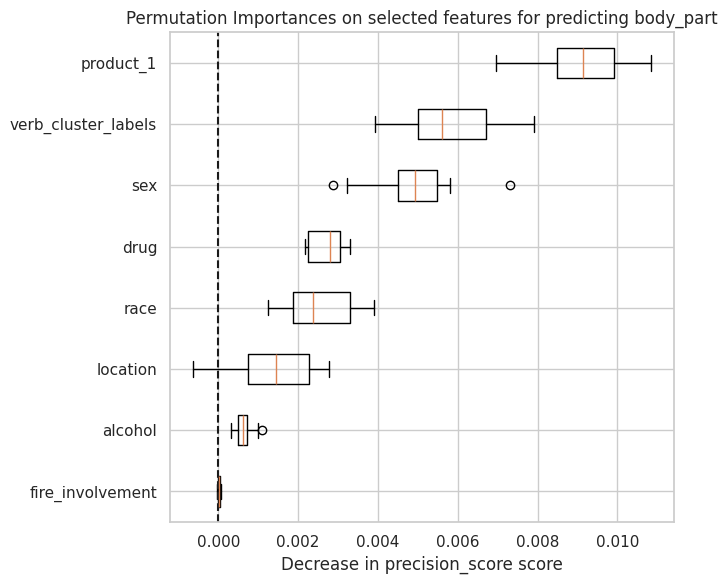

In [15]:
make_importance_plots('body_part', labels, thres_counts=1000)

From the cross validation score and permuation importance( we avoid impurity based feature importance as product_1 has high cardinality), we can gather that the verb describing the action clusterd into 10 groups has an impact on the body part being affected. We use precision score (average=micro) for scoring.

Now we will evaluate semantic search using FAISS

In [16]:
# Create a FAISS vector store database with the host provided embeddings of primary narrative
def load_embeddings_to_faiss(path, gpu=False):
    data = pd.read_parquet(path)
    embeds_narrative = np.vstack(data['embedding'])
    n_dimensions = embeds_narrative.shape[1]
    # We will create an index of type FlatL2, there are many kinds of indexes, you can look at it in their repo.
    fastIndex_cpu = faiss.IndexFlatL2(n_dimensions)
    # rane search does not work with gpu
    if gpu:
        res = faiss.StandardGpuResources()  # use a single GPU
        fastIndex = faiss.index_cpu_to_gpu(res, 0, fastIndex_cpu)
    else:
        fastIndex = fastIndex_cpu
    # Add the embedding vector to faiss index, it should be of dtype 'float32'
    fastIndex.add(embeds_narrative.astype('float32')) 
    return fastIndex

# get the embeddings of query from openai
def get_query_embeds(groups_activity, file_name=''):
   
    activities = groups_activity.keys()
    q_template = groups_activity.values()
    if not os.path.isfile(file_name):
        print ('Getting embeddings from OpenAI')
        embedding_cls = [OpenAIEmbeddingsWithKey.embed_query(q) for q in q_template]
        embedding_cls = np.asarray(embedding_cls).astype('float32')
        print (embedding_cls.shape)
        embeds = {k:v for k, v in zip(activities, embedding_cls)}
        embeds['template'] = groups_activity
        if file_name!='':
            pickle.dump(embeds, open(file_name, 'wb')) 
    else:
        print ('Loading saved..')
        embeds = pickle.load(open(file_name, 'rb'))
    return embeds

# perform range search given query embedings and some threshold value 
def extract_query_result(embeds, thres=0.44):
    df = load_primary(primary_path)
    activities = embeds.keys()
    for q in embeds.keys():
        df[q] = [1]*df.shape[0]
    for query_text, embedding_q in embeds.items():
        result = fastIndex.range_search(embedding_q.reshape(1, -1).astype('float32'), thres)
        df.loc[result[2], query_text]=result[1]

    df_extracted_semantic = df[df[activities].sum(axis=1)!=len(activities)]
    print (df_extracted_semantic.shape, df.shape) 
    return df_extracted_semantic

# https://opentsne.readthedocs.io/en/latest/examples/index.html
# From community code:  https://www.drivendata.org/competitions/217/cdc-fall-narratives/community-code/50/
def reduce_dimension(x, nb_samples = 20000):
    np.random.seed(13)
    indices = np.random.permutation(list(range(x.shape[0])))
    reverse = np.argsort(indices)

    x_sample, x_rest = x[indices[:nb_samples]], x[indices[nb_samples:]]

    sample_affinities = openTSNE.affinity.PerplexityBasedNN(
        x_sample,
        perplexity=500,
        n_jobs=-1,
        random_state=0,
        verbose=True,
    )

    sample_init = openTSNE.initialization.pca(x_sample, random_state=42)
    sample_embedding = openTSNE.TSNE(n_jobs=-1).fit(affinities=sample_affinities, 
                                                    initialization=sample_init)
    rest_init = sample_embedding.prepare_partial(x_rest, k=1, perplexity=1/3)
    init_full = np.vstack((sample_embedding, rest_init))[reverse]

    embeddings2 = init_full / (np.std(init_full[:, 0]) * 10000)
    return embeddings2


# get sentence embeddings using sentence_transformers
def get_embeddings(sentences, pretrained="paraphrase-multilingual-mpnet-base-v2"):
    model = SentenceTransformer(pretrained)
    embeddings = model.encode(sentences, show_progress_bar=True)
    return embeddings


# silhouette score and calinski_harabasz score as evaluation metrics of cluster results
def usup_cluster_score(embedings, labels):
    print (embedings.shape, labels.shape)
    ss = silhouette_score(embedings, labels)
    chs = calinski_harabasz_score(embedings, labels)
    #dbs  = davies_bouldin_score(embedings, labels)
    print (f'silhouette_score = {ss}')
    print (f'calinski_harabasz_score = {chs}')
    #print (f'davies_bouldin_score = {dbs}')
    
# convenience function that puts it all together, i.e 
#     get query embedings
#     do FAISS range search, 
#     clean narrative, label if multiple queries
#     get embeddings of the cleaned text, 
#     reduces the dimension then evalute using sillhoute and calinski_harabasz score

def get_query_results(kv, remove_to_clean =['body_part', 'location'] , thres=0.37, file_name='', add_cls=True):
    cls = list(kv.keys())
    q_template = [v for v in kv.values()]
    for i, v in enumerate(q_template):
        print (i, v)
    embeds = get_query_embeds(kv, file_name=file_name)
    print (embeds['template'])
    embeds.pop('template')
    df_extracted_semantic = extract_query_result(embeds, thres=thres).reset_index()
    df_extracted_semantic["label"] = [cls[ix] for ix in np.argmin(df_extracted_semantic[cls].values, axis=1)]
    print (df_extracted_semantic.shape)
    print (df_extracted_semantic.label.value_counts()) 
    stop_words = stop_words_base.copy()

    # remove already existing values from narrative
    if 'body_part' in remove_to_clean:
        stop_words = add_body_part_to_stop_words(stop_words)
    if 'location' in remove_to_clean:
        stop_words = add_location_to_stop_words(stop_words)
    if 'product' in remove_to_clean:
        stop_words = add_product_to_stop_words(stop_words)

    cleaner = lambda x: clean_narrative_semantics(x, stopwords=stop_words, filter_vb=None, 
                                                  filter_words=['nursing', 'house'])

    df_extracted_semantic['text'] = df_extracted_semantic.narrative.progress_apply(cleaner)
    df_extracted_semantic['text'] = df_extracted_semantic.text.apply(lambda x: x.replace('patient', ''))

    if 'product' not in remove_to_clean:
        df_extracted_semantic = add_product_information(df_extracted_semantic, cls, add_cls = add_cls) 
    if len(kv)>1:
        clean_embeddings = get_embeddings(list(df_extracted_semantic["text"]))
        embeddings2 = reduce_dimension(clean_embeddings)
        df_extracted_semantic["emb0"] = embeddings2[:,0]
        df_extracted_semantic["emb1"] = embeddings2[:,1]
        usup_cluster_score(embeddings2, df_extracted_semantic.label.values)
    return df_extracted_semantic
    

In [17]:
fastIndex = load_embeddings_to_faiss(embedding_path)
fastIndex

<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f0061508720> >

In [19]:
OpenAIEmbeddingsWithKey= OpenAIEmbeddings(openai_api_key=openai_key_uk, model_kwargs={'temperatue' : 0.0})

First let us get a sense of how relevant the returned results are through a simple search.

In [20]:
qe = OpenAIEmbeddingsWithKey.embed_query('tripped on cord')
D, I = fastIndex.search(np.asarray([qe]).astype('float32'), 10)     # actual search
show_samples(df.iloc[I.flatten()], col='diagnosis', n=10)

narrative -> 79 YOF TRIPPED OVER AN EXTENSION CORD. DX: CLOSED HEAD INJURY.
clean text-> internal injury -> 
____________________________________________________________________
narrative -> 67YOF TRIPPED OVER AN EXTENSION CORD AND LANDED ONTO A LADDER THAT WAS ON THE GROUND SUSTAINED A RIB FX
clean text-> fracture -> 
____________________________________________________________________
narrative -> 81YF WAS PLUGGING A CORD WHEN TRIPPED&FELL, DX: KNEE CONTUSION
clean text-> contusions, abr. -> 
____________________________________________________________________
narrative -> 72YOF TRIPPED AND FELL ON AN ELECTRIC CORD--DX:CONTUSION HEAD+KNEE PAIN
clean text-> contusions, abr. -> 
____________________________________________________________________
narrative -> 70YOM TRIPEPD OVER AN EXTENSION CORD AT HOME AND FELL ONTO KNEE SUSTAINED A CONTUSION TO KNEE
clean text-> contusions, abr. -> 
____________________________________________________________________
narrative -> 71 YOF GROUND LEVEL 

As we can see above our setup returns relevant result. We will though, use 'range search' instead as this operation returns all index calculated from distance metric between query and value embeddings and a specified threshold enabling us to draw conclusions about the distribution.

We will start with fall when a <span style='color:brown'>Walker is involved and compare it with fall in Stairs</span>. Walker is not in product mapping specified in coding manual so without searching for it in the narratives, further study on it would not have been possible.

At this point we would like to mention that, as shown in introductary figure of broadly categorizing activities, that some context is good for forming queries but too much may not be useful, given that our narrativea are short with repetative words for location, body_part, diagnosis etc. Including too much context may lead to too many matches hence loosing the specificity desired. Of course you can counter this with lowering the threshold, in which case too few samples maybe returned. This can be
best seen by forming your own queries and inspecting the result. We believe in practice, forming a query with action and 1 or 2 context is best.

In [23]:
# Here we setup two queries for camparison where key is just a label and value is the actual query to be searched
groups_walker_stair = {'walker' : 'using walker', 'stairs': 'going down stairs'}
df_walker_ex = get_query_results(groups_walker_stair, remove_to_clean = ['body_part','location'], 
                                 thres=0.37, file_name='')

df_walker_ex = df_walker_ex[df_walker_ex.text.apply(lambda x: not 'not mentioned' in x)]

0 using walker
1 going down stairs
Getting embeddings from OpenAI
(2, 1536)
{'walker': 'using walker', 'stairs': 'going down stairs'}
(6219, 24) (115128, 24)
(6219, 26)
label
stairs    4852
walker    1367
Name: count, dtype: int64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6219/6219 [00:01<00:00, 4019.30it/s]


Batches:   0%|          | 0/195 [00:00<?, ?it/s]

===> Finding 1500 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 7.17 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 4.39 seconds
===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
(6219, 2) (6219,)
silhouette_score = 0.3793399338389052
calinski_harabasz_score = 3921.143221035763


In [24]:
# show a few random samples
show_samples(df_walker_ex, n=5)

narrative -> 81YOM PRESENTS AFTER FALLING DOWN THE STAIRS. C/O LAC TO TOP OF HEAD. PT WAS WALKING UPSTAIRS WITH CANE WHEN INCIDENT OCCURRED.  DX: FALL; INABILITY TO WALK
clean text-> falling down stairs -> stairs
____________________________________________________________________
narrative -> 72YOF MISSED A STEP WHILE WALKING DOWN THE STAIRS TO HER BASEMENT AND FELL CAUSING AN INJURY TO HER LEFT ANKLE AND ABRASIONS TO HER BILATERAL KNEES DX: CLOSED FRACTURE OF DISTAL END OF LEFT FIBULA
clean text-> missed step walking down stairs basement -> stairs
____________________________________________________________________
narrative -> 81 YOF AT HOME SLIPPED AND FELL DOWN TWO STEPS, C/O PAIN LEFT KNEE, DX: FRACTURE DISTAL FEMUR
clean text-> slipped and fell due to stairs or steps -> stairs
____________________________________________________________________
narrative -> 84YOM FELL DOWN A FLIGHT OF TWO STEPS STRUCK CHEST ON THE STAIRCASE TO THE BASEMENT FLOOR DX: HEMATOMA TO BACK OF HEAD LACE

[Text(0.5, 1.0, 'Compare cluster between fall while using walker and going down stairs')]

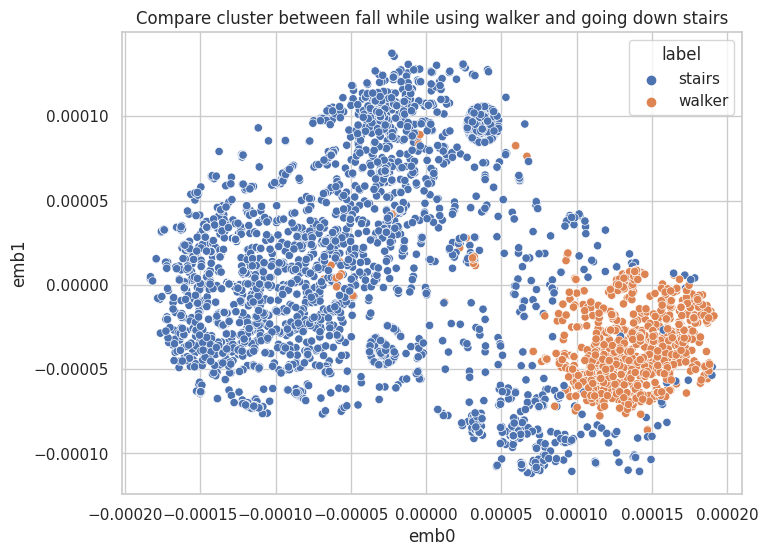

In [25]:
sns.set(style="whitegrid", rc={'figure.figsize':(8, 6)})
sns.scatterplot(data=df_walker_ex, x='emb0', y='emb1', hue='label').set(
    title='Compare cluster between fall while using walker and going down stairs')

Silhouette_score suggests good cohesion of cluster and intra cluster seperability. The clean text is concise and mentions the action and product combined to cause the fall. Now we look at how they are distributed according to age.

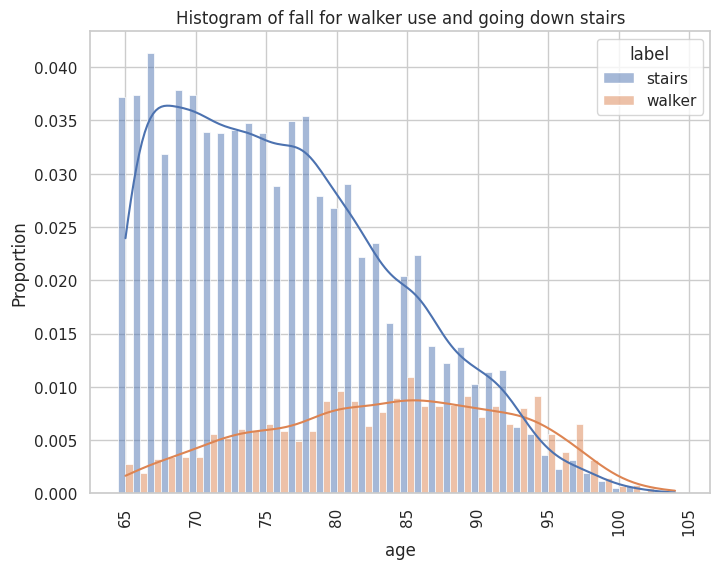

In [26]:
h = sns.histplot(df_walker_ex, x='age',  kde=True, discrete=True,
                 stat = 'proportion', hue='label', multiple='dodge').set(
    title='Histogram of fall for walker use and going down stairs')
h = plt.xticks(rotation=90)

<span style="color:blue">Unlike the gaussian distribution with peak at age 85 for fall using walker,  fall going down steps is 
declining sharply from age 76 (long-tailed), as age progresses. This could perhaps be explained from the fact that as age 
progresses more people will start using walker while they limit the use of stairs</span>

An alternative to FAISS semantic search is to pass the narrative through OpenAI chatgpt3.5 turbo. 
We evaluate this method and compare it to ours before moving forward.

In [27]:
import openai
openai.api_key = openai_key_uk

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0.0, 
    )
    return response.choices[0].message["content"]

In [28]:
# there is a response file already obtained for loading
# set to false ensuring you have a working openai key
load_precomputed = True

In [33]:
%%time
RESPONSE_DIR = DATA_DIR / 'interim/response/'
os.makedirs(RESPONSE_DIR, exist_ok=True)
# control the numbers of items to send via start_index, end_index and num_items_per_request
# currently for demonstration we break after one iteration and load n samples already obtained
# remove the break if you would like to gather more of the response from chatgpt.
start_index = 0 
end_index = df.shape[0]
num_items_per_request = 20 # 200 max
response_openai = {}
if load_precomputed is True:
    print ('Loading precomputed ...')
    response = json.load(open(RESPONSE_DIR / f'response_{str(0)}.json', 'r'))
    response_openai[start_index]=response
else:
    for i in tqdm(range(start_index, end_index, num_items_per_request)):
        item = json.dumps(df.iloc[start_index:start_index+num_items_per_request].narrative.values.tolist())
        prompt = f""" What was the subject doing before the fall in each text inside double quotation
        in the text delimited by triple backticks.
        text: ```{item}```..
            """
        try:
            response = get_completion(prompt)
            json.dump(response, open(RESPONSE_DIR / f'response_{str(start_index)}.json', 'w'))
            response_openai[start_index]=response
            start_index = start_index+num_items_per_request
        except:
            print ('Exception....sleeping..')
            time.sleep(60)
        break
        

Loading precomputed ...
CPU times: user 1.21 ms, sys: 0 ns, total: 1.21 ms
Wall time: 829 µs


In [34]:
import glob
# lets look at the response returned by openai chatgpt 3.5 turbo 
# the reurned results are cleaned removing bullet list numbering        
doing_before = []
g = glob.glob(str(RESPONSE_DIR / '*.json'))
for gi in tqdm(g):
    res = json.load(open(gi))
    response = res.split('\n')
    response = [item for item in response if item!='']
    for item in response[1::]:
        item = item if ' - ' not in item else item.split(' - ')[1]
        r = " ".join(re.split(r'\s*(?:\d+\.|[A-Za-z]+\))\s*', item)).strip()
        r = r.replace('The activity before the fall was ','')
        if '"' in r:
            continue
        doing_before.append(r)
doing_before

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1448.31it/s]


['Not specified.',
 'Showering.',
 'Getting up from the couch.',
 "Visiting a friend's house.",
 'Standing on a step stool.',
 'Standing on a folding lawn chair.',
 'Not specified.',
 'Slipping and falling at home.',
 'Getting up from the couch.',
 'Not specified.',
 'Going down a flight of stairs.',
 'Slipping and falling at the nursing home.',
 'Not specified.',
 'Taking down Christmas lights from the roof.',
 'Dancing with his wife.',
 'Not specified.',
 'Not specified.',
 'Not specified.',
 'Not specified.',
 'Slipping out of bed while wearing a silky nightgown.']

We clearly see a very consise activity description returned from openai with the extra irrelevant information stripped out. While convinient the response takes time (we additionally send only 20 narratives at a time to be within token limits). Executing all the narratives will need additional constraint to be set for rate limit. For the 115128 primary narratives, this will take a long time.

We feel simple semantic search as described above is adequate and significantly faster, we will however analyse further ~5000 samples using this approach to demonstrate an alternative. These were extracted beforehand and simply loaded here for demonstration. 

In [35]:
tmp_openai_activities = json.load(open(DATA_DIR / 'interim/openai_precipitating.json'))
openai_activities = []
for item in tmp_openai_activities:
    item = item.replace('.','').replace(',',' ')
    new_item = []
    for w in item.split(' '):
        if w not in ['fell', 'fall', 'Fell', 'Fall']:
            # we removes stop words , body part, location for cmarision to faiss results as above
            if w not in stop_words_base:
                if w not in body_part:
                    if w not in location:
                        new_item.append(w)
    openai_activities.append(' '.join(new_item).lower())
    #openai_activities.append(item)
print (len(openai_activities))
openai_activities = [item for item in openai_activities if item not in ['no specific activity mentioned', 
                     'not specified', 'unknown']]
openai_activities = [item for item in openai_activities if item!='']
print (len(openai_activities))

5104
4963


In [36]:
# we obtain the reduced embeddings for clustering
openai_embeddings = get_embeddings(openai_activities)
reduced_openai_embeddings = reduce_dimension(openai_embeddings)

Batches:   0%|          | 0/156 [00:00<?, ?it/s]

===> Finding 1500 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.94 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.05 seconds
===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds


In [37]:
# using kmeans++ we evalute the clusters using silhouette_score
model_openai = KMeans(n_clusters = 7, init='k-means++',random_state=99) # n_jobs = -1
model_openai.fit(reduced_openai_embeddings)

dfo = pd.DataFrame(reduced_openai_embeddings, columns=['emb0', 'emb1'])
dfo['label'] = model_openai.labels_

score = silhouette_score(reduced_openai_embeddings, dfo.label, metric='euclidean')
print (f' silhouette_score {score}')

 silhouette_score 0.4312853065240059


0  -->  falling standing position onto chair
1  -->  walking down handicap ramp walker
2  -->  losing balance bathroom
3  -->  getting out of bed  weak stand  crumpled floor
4  -->  stair chairs coming down stairs hit chest onto table bottom of stairs
5  -->  slipped on antifreeze
6  -->  falling down on floor doctor's office
{0: 'falling standing position onto chair', 1: 'walking down handicap ramp walker', 2: 'losing balance bathroom', 3: 'getting out of bed  weak stand  crumpled floor', 4: 'stair chairs coming down stairs hit chest onto table bottom of stairs', 5: 'slipped on antifreeze', 6: "falling down on floor doctor's office"}


<Axes: xlabel='emb0', ylabel='emb1'>

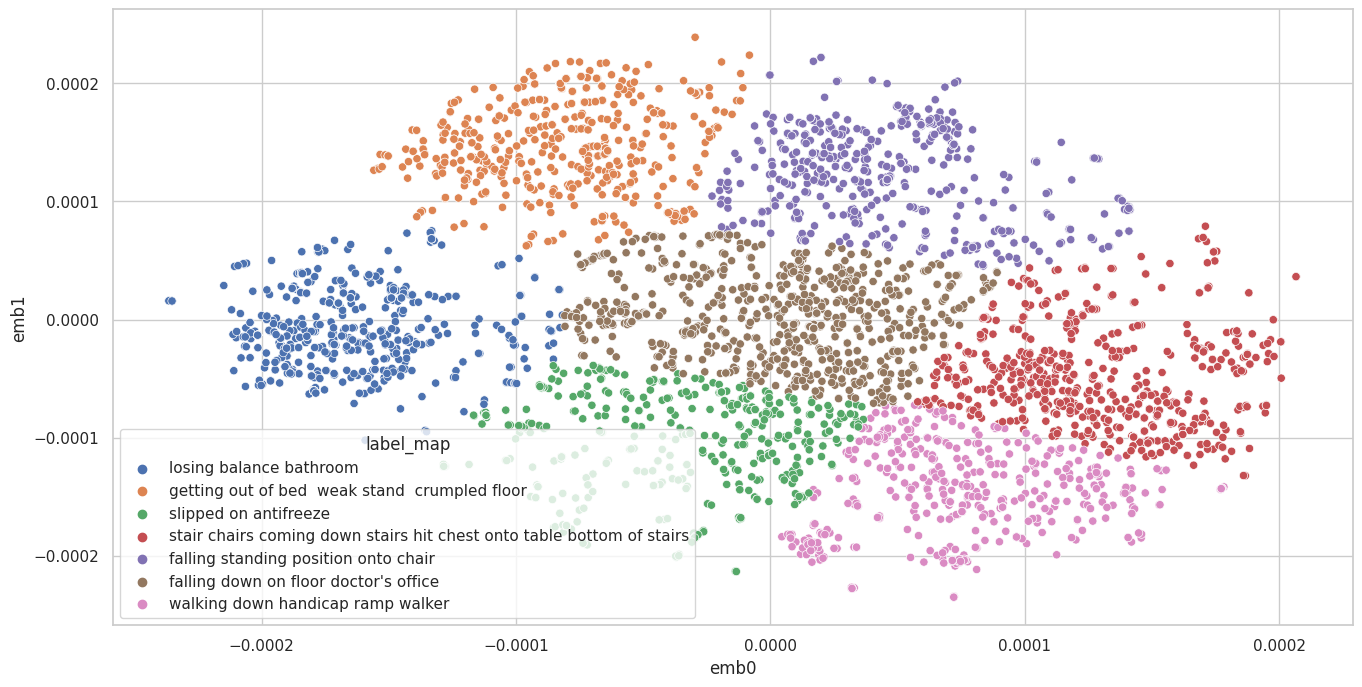

In [38]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity    
# lets see exactly how each centroid maps to the text
center_ = {}
for i, cc in enumerate(model_openai.cluster_centers_):
    ix = np.argmin(euclidean_distances([cc], dfo[['emb0', 'emb1']].values))
    center_[i] = openai_activities[ix]

for k, v in center_.items():
    print (k,' --> ' ,v)
dfo['label_map']  = dfo.label.map(center_)
print(center_)

sns.set(style="whitegrid", rc={'figure.figsize':(16, 8)})
sns.scatterplot(data=dfo, x='emb0', y='emb1', hue='label_map')

In [39]:
# we use the full embedings for cosine similarity 
walker_embeddings = get_embeddings(df_walker_ex[df_walker_ex.label=='walker'].text.values.tolist())
stair_embeddings = get_embeddings(df_walker_ex[df_walker_ex.label=='stairs'].text.values.tolist())

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

Batches:   0%|          | 0/150 [00:00<?, ?it/s]

In [40]:
# compare cosine similarities between embeddings of openai chatgpt results and our embeddings of cleaned text

dws = df_walker_ex[df_walker_ex.label=='stairs']
for u in list(center_.keys()):
    sim_1 = cosine_similarity(openai_embeddings[dfo[dfo.label==u].index],walker_embeddings).mean()
    sim_2 = cosine_similarity(openai_embeddings[dfo[dfo.label==u].index],stair_embeddings).mean()
    print (f'{u}, centroid text ->{center_[u]}, sim (walker) {sim_1}, sim (stairs) {sim_2}')

0, centroid text ->falling standing position onto chair, sim (walker) 0.29942819476127625, sim (stairs) 0.26690536737442017
1, centroid text ->walking down handicap ramp walker, sim (walker) 0.4353788495063782, sim (stairs) 0.3398977816104889
2, centroid text ->losing balance bathroom, sim (walker) 0.23835740983486176, sim (stairs) 0.26565754413604736
3, centroid text ->getting out of bed  weak stand  crumpled floor, sim (walker) 0.2947665750980377, sim (stairs) 0.2931913733482361
4, centroid text ->stair chairs coming down stairs hit chest onto table bottom of stairs, sim (walker) 0.3719065189361572, sim (stairs) 0.540742814540863
5, centroid text ->slipped on antifreeze, sim (walker) 0.3004002571105957, sim (stairs) 0.3109472393989563
6, centroid text ->falling down on floor doctor's office, sim (walker) 0.34481990337371826, sim (stairs) 0.4301069974899292


From the text of cluster centroid we see the different prodcut combined with different actions constitute a precipitating event such as 'Trying to sit on chair' , 'Going to the bathroom' and 'Slipping on a wet floor'. These we can also extract simply using FAISS and cleaned narrative as shown above but much faster (just cpu). 
Here one should keep in mind that the text being comapred have only few words, i.e 'getting down chair' is compared with 'getting down stairs' where the only difference is the product, i.e chair or stairs, so there will be some similarity due to action of getting down, regardless of the product and hence some similarity will always exists. Above we see, for label 1 ('down flight of concrete steps'), cosine similarity is much closer to stairs than walker and similarly for 3 ('slipped ambulating walker'), cosine similarity for walker is more closer than for stairs.

The value of a cleaned text is for presenting a concise representation of precipitating event. Its also better in calculating the embedding for cluster analysis. But it plays no part in analysing the distribution of the result returned from a query. So we kept the cleaning to a minimum and did not go into a much elaborate parsing that might have generated a better formed cleaned text. Aside if we were to use chatgpt, the returned text would have needed another embeddings calculation and loaded to FAISS for similarity search or clustering approach to study some desired distributions. This could have meant two passes using an LLM and inherent noise in the process.

<span style='color:brown'> Semantic search with product only </span>

In [41]:
vc_describe = df.product_1.describe() 
print (vc_describe)
print ()
vc_product = df.product_1.value_counts().head(6)
print (vc_product)
print ()
top_appearance = vc_product.sum()/df.shape[0]*100
floor_appearance = df[df.narrative.apply(lambda x: "floor" in x.lower())].shape[0]
print (f'Num product {len(vc_product)} out of {df.product_1.unique().shape[0]} contributes \
to {top_appearance} % of samples')
print (f'floor appearing in narrative {floor_appearance}')

count                           115128
unique                             496
top       floors or flooring materials
freq                             33204
Name: product_1, dtype: object

product_1
floors or flooring materials                 33204
beds or bedframes, other or not specified    14460
stairs or steps                              13132
chairs, other or not specified                5896
bathtubs or showers                           4590
toilets                                       3595
Name: count, dtype: int64

Num product 6 out of 496 contributes to 65.03804461121534 % of samples
floor appearing in narrative 46753


We see from the analysis above that top 6 of the product are involved in 65% of the samples. Furthermore some of the products are similar, so we will group the items accordingly. We make 4 classes based on product
description only. Items such as chairs and couch or bathroom and toilet are grouped together as shown below. We also skip floor as a seperate class as its frequency is relatively high (46753 samples), and examples such as "Fell to the floor" is uninformative in knowing the cause of the fall.

In [42]:
groups_product = {'chair': 'chairs couch stool',
                   'bed': 'beds ',
                   'steps': 'stairs steps ladder', 
                   'bath': 'bathtubs bathroom shower toilet'}
thres = 0.43
# In addition to the stop_words we remove body_part and location
remove_to_clean =['body_part', 'location'] 
df_product = get_query_results(groups_product, remove_to_clean=remove_to_clean, 
                               thres=thres, file_name='')

0 chairs couch stool
1 beds 
2 stairs steps ladder
3 bathtubs bathroom shower toilet
Getting embeddings from OpenAI
(4, 1536)
{'chair': 'chairs couch stool', 'bed': 'beds ', 'steps': 'stairs steps ladder', 'bath': 'bathtubs bathroom shower toilet'}
(39317, 26) (115128, 26)
(39317, 28)
label
steps    15209
bed      13133
chair     6057
bath      4918
Name: count, dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39317/39317 [00:13<00:00, 2987.52it/s]


Batches:   0%|          | 0/1229 [00:00<?, ?it/s]

===> Finding 1500 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 34.97 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 11.15 seconds
===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 3.58 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.06 seconds
(39317, 2) (39317,)
silhouette_score = 0.3301979404045318
calinski_harabasz_score = 25244.6007886939


<Axes: xlabel='emb0', ylabel='emb1'>

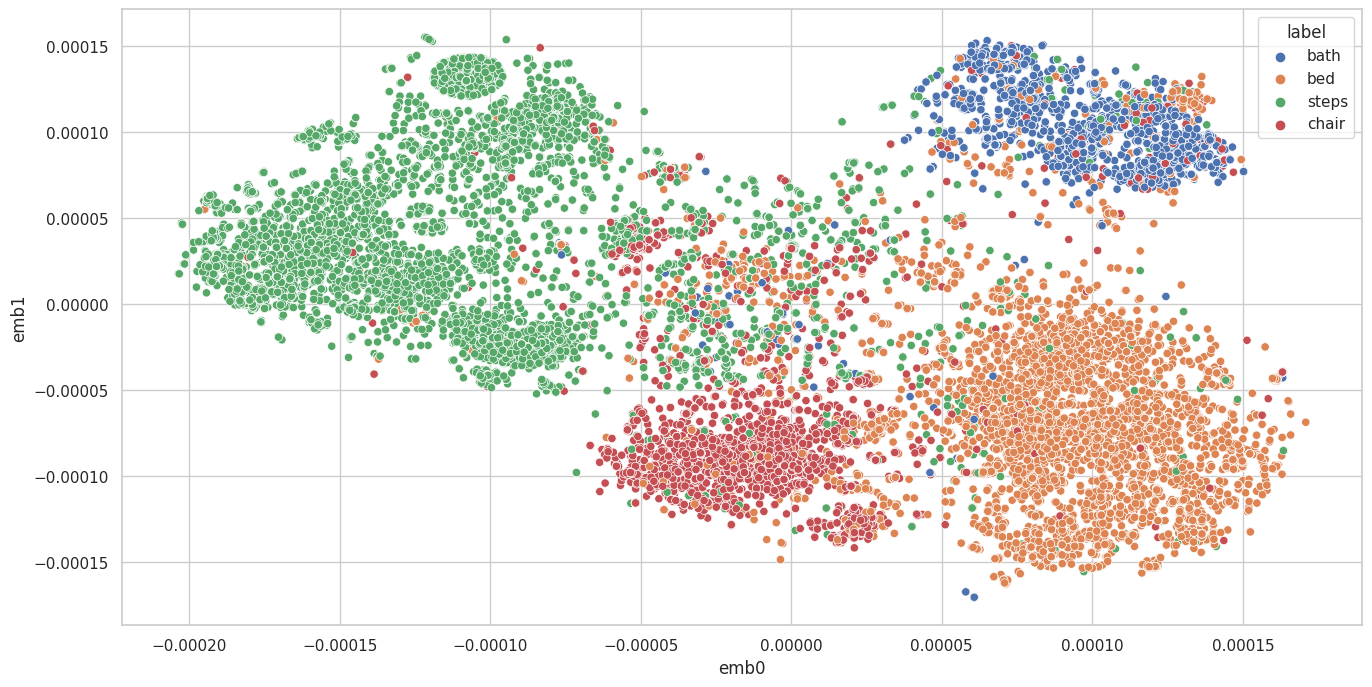

In [43]:
# we clearly see highly cohesive cluster formations
sns.set(style="whitegrid", rc={'figure.figsize':(16, 8)})
sns.scatterplot(data=df_product, x='emb0', y='emb1', hue='label')

In [44]:
show_samples(df_product, n=5)

narrative -> 88YOM ROLLED OUT OF BED AND HIT HIS HEAD. HAS ABRASIONS AND SKIN TEARS. DX: HEAD INJURY
clean text-> rolled out of bed -> bed
____________________________________________________________________
narrative -> 79YOM C/O FALL.  PT SAT IN CHAIR WHERE THE CHAIR COLLAPSED.  PT HAS BRUISE TO SHOULDER.  DX: WEAKNESS
clean text-> complains of fall while chair -> chair
____________________________________________________________________
narrative -> 67 YOM-DRANK 5 BEERS-GOING UP STEPS AT HOME-TRIPPED & FELL FORWARD-NO ETOH DRAWN IN ED DX:  WRIST FRACTURE
clean text-> tripped on stairs or steps -> steps
____________________________________________________________________
narrative -> 67YOF PT WAS HIKING DOWN A ROCKY PATH SLIPPED AND FELL CUTTING LEG ON ROCKS DX 4CM LACERATION LT LOWER LEG
clean text-> slipped and fell due to exercise (activity or apparel, w/o equip) -> steps
____________________________________________________________________
narrative -> 72YOM WAS TRYING TO GET OUT 

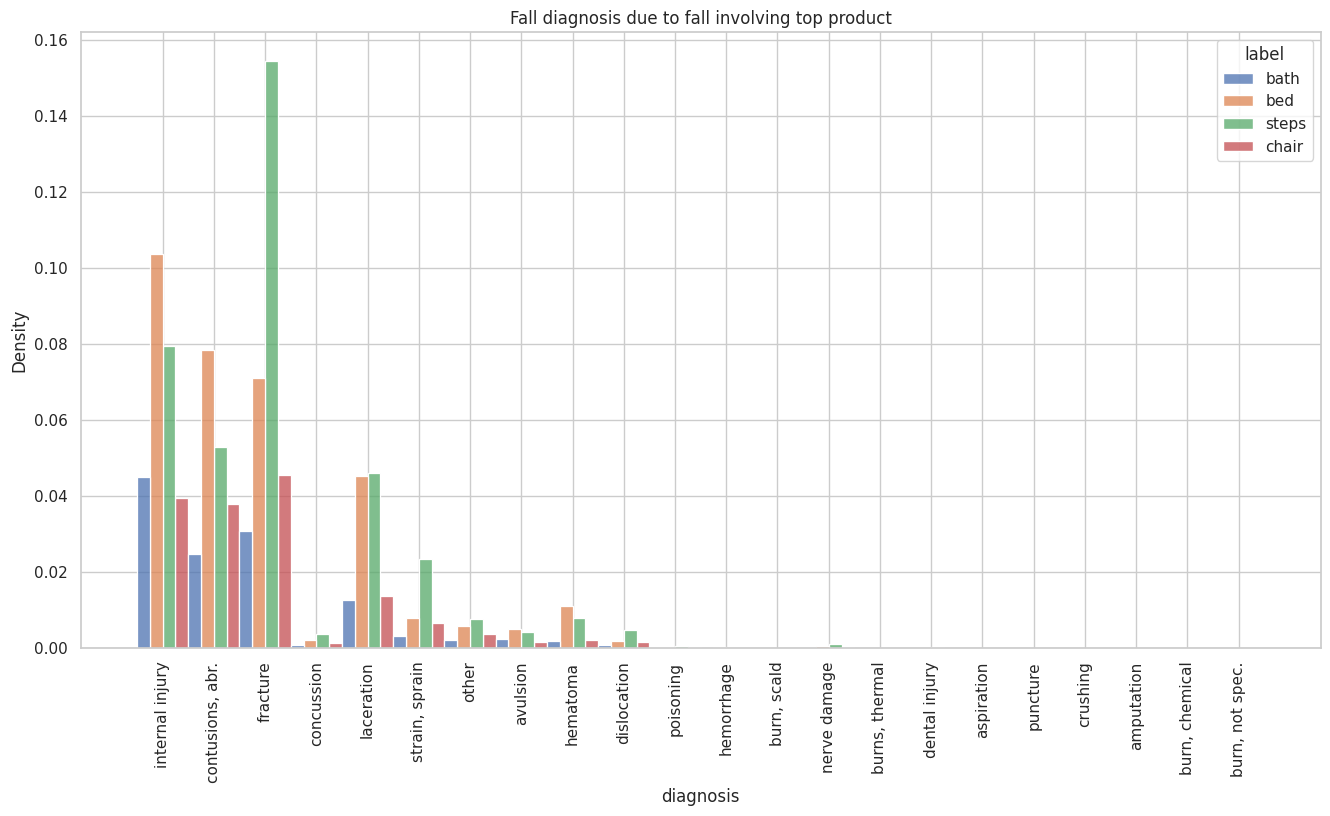

In [45]:
# Lets analyse how fall from stairs or steps differs from the rest
h  = sns.histplot(df_product, multiple='dodge', stat="density",
           x='diagnosis', hue='label').set(title='Fall diagnosis due to fall involving top product')
h = plt.xticks(rotation=90)

<span style='color:blue'> As expected fracture is almost twice as high as the count of the next highest diagnosis when fall from steps (height) occurs.
While falling from bed causes internal injury the most. </span>

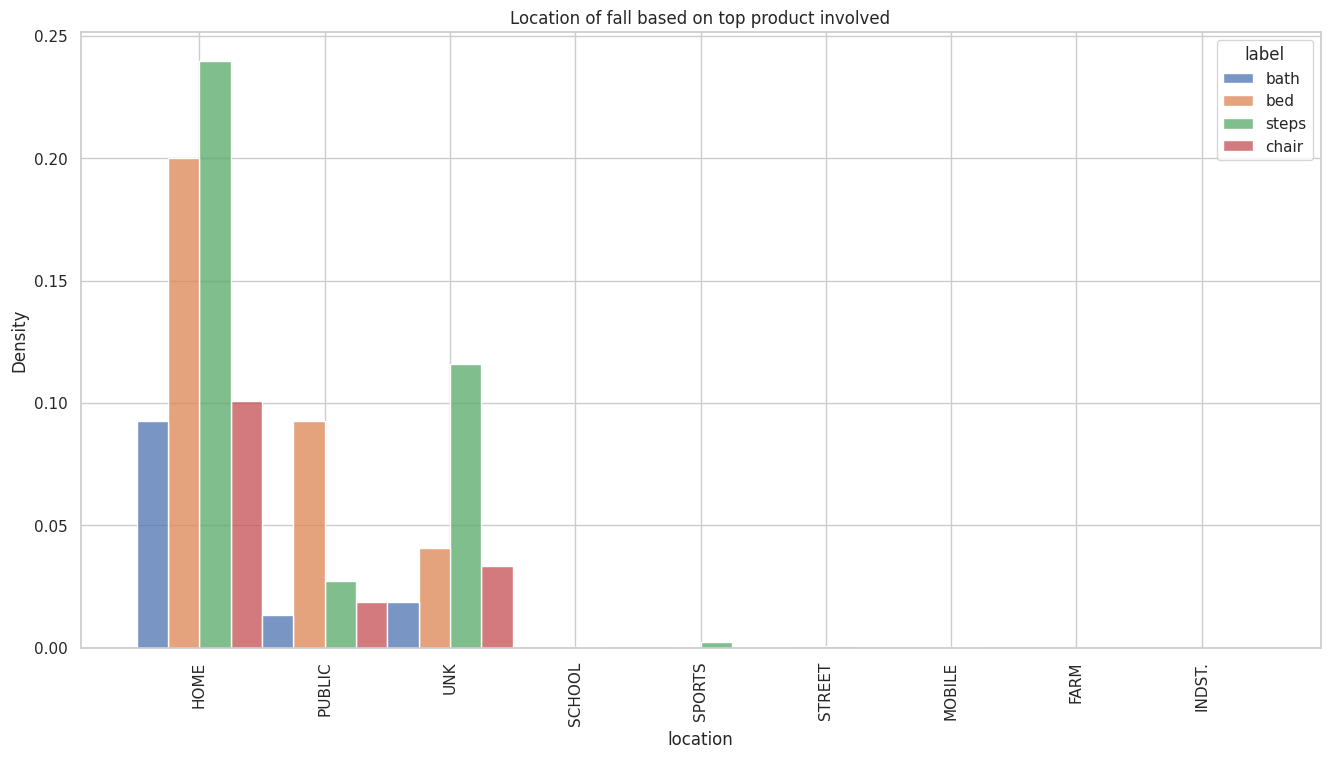

In [46]:
h  = sns.histplot(df_product, multiple='dodge', stat="density",
           x='location', hue='label').set(title='Location of fall based on top product involved')
h = plt.xticks(rotation=90)

<span style='color:blue'>  In the above histplot we clearly and surprisingly see that in PUBLIC(nursing home) counts of falling from bed is very high.</span>

Lets do <span style='color:brown'>slipped and tripped</span>, and see which body parts is affected by each and the final diagnosis. Similar to prodcut semantic search, while we could have done keyword search here due to them being mentioned explicitly as per coding guide, there are instances where it is implied or variations such as just slip or trip are used, so we do semantic search and analyse the result.

In [47]:
groups_slip_trip = {'slip': 'slipped',
                   'trip': 'tripped'}
thres = 0.38
df_slip_trip = get_query_results(groups_slip_trip, remove_to_clean = ['body_part','location'], 
                                 thres=0.37, file_name='', add_cls=False)

0 slipped
1 tripped
Getting embeddings from OpenAI
(2, 1536)
{'slip': 'slipped', 'trip': 'tripped'}
(34302, 24) (115128, 24)
(34302, 26)
label
trip    19969
slip    14333
Name: count, dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34302/34302 [00:05<00:00, 6700.69it/s]


Batches:   0%|          | 0/1072 [00:00<?, ?it/s]

===> Finding 1500 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 37.23 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 19.76 seconds
===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.64 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.05 seconds
(34302, 2) (34302,)
silhouette_score = 0.157743729869337
calinski_harabasz_score = 6226.287522468331


narrative -> 65 YOF LOST BALANCE AND FELL STRIKING HEAD WHILE GETTING UP FROM TOILETDX: FALL
clean text-> lost balance -> trip
____________________________________________________________________
narrative -> 68YOM WAS WALKING AND SLIPPED IN A HOLE IN THE FLOOR AND FELL ONTOP FACE DX: NASAL FX
clean text-> slipped and fell due to floors or flooring materials -> slip
____________________________________________________________________
narrative -> 66YOF FELL DOWN 5 STEPS DX L TIBIA FX, FALL
clean text-> fell down 5 steps -> trip
____________________________________________________________________
narrative -> 82YOF TRIPPED AND FELL ON AN ELECTRICAL EXTENSION CORD. DX: LEFT RAIDUS FX, LEFT SHOULDER SPRAIN.
clean text-> tripped on extension cords -> trip
____________________________________________________________________
narrative -> 77YOF TRIPPED GOING UP THE STEPS HITING FACE ON THE FLOOR.  AND INJURED HIP.  DX FOREHEAD LACERATION AND CONTUSION TO HIP
clean text-> tripped on stairs or 

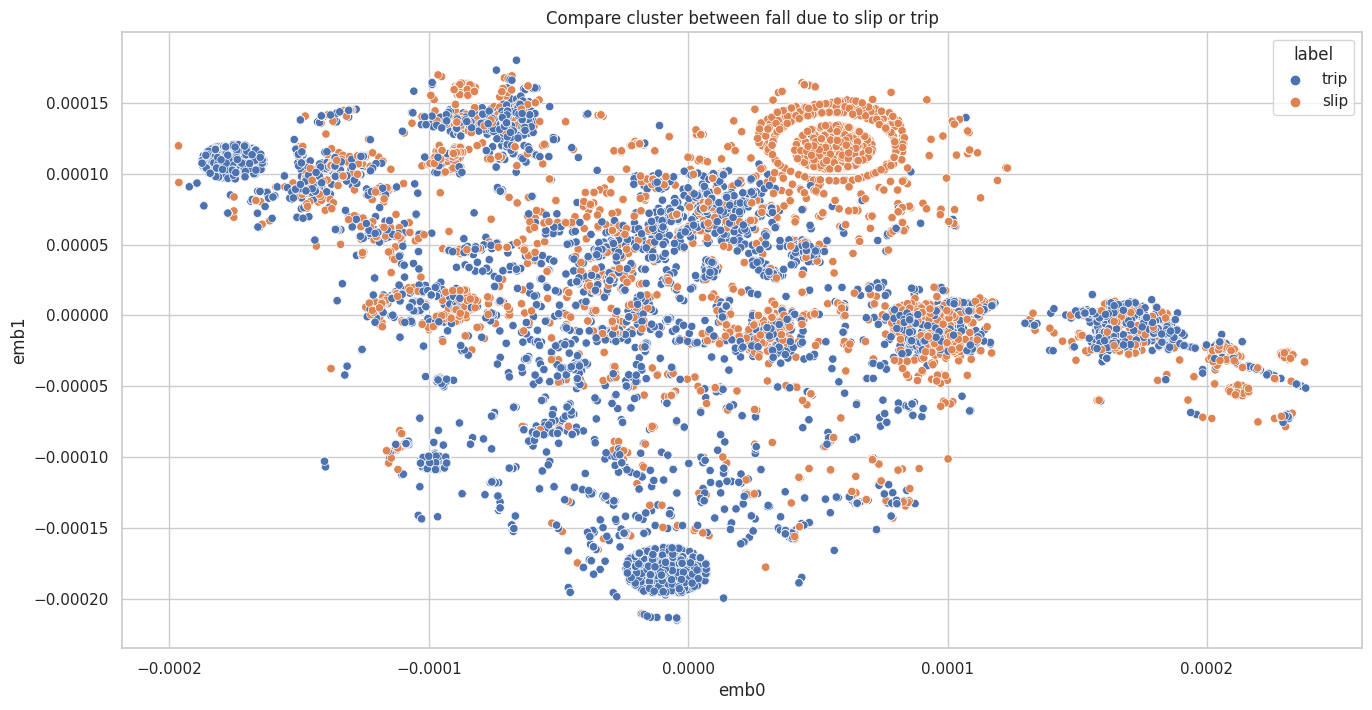

In [48]:
sns.set(style="whitegrid", rc={'figure.figsize':(16, 8)})
sns.scatterplot(data=df_slip_trip, x='emb0', y='emb1', hue='label').set(
    title='Compare cluster between fall due to slip or trip')
show_samples(df_slip_trip)

In [49]:
print (df_slip_trip.product_1.value_counts().head(8))
print()
print ('samples in top 8 ->', df_slip_trip.product_1.value_counts().head(8).sum()/df_slip_trip.shape[0]*100, '%')
df_slip = df_slip_trip[df_slip_trip.label=='slip']
df_trip = df_slip_trip[df_slip_trip.label=='trip']

product_1
floors or flooring materials                 9238
stairs or steps                              4779
beds or bedframes, other or not specified    2461
bathtubs or showers                          1772
rugs or carpets, not specified               1407
footwear                                     1404
chairs, other or not specified               1128
toilets                                       696
Name: count, dtype: int64

samples in top 8 -> 66.71622645909859 %


Above we see formation of island of highly cohesive cluster which can be attributed to 'slipped in floor'  or
'tripped in stairs' where floor and stairs are product involved in high fall incident count. But there are also scaterring of
slipped and tripped events which can be attributed to them occuring in combination with other less frequently occuring product.

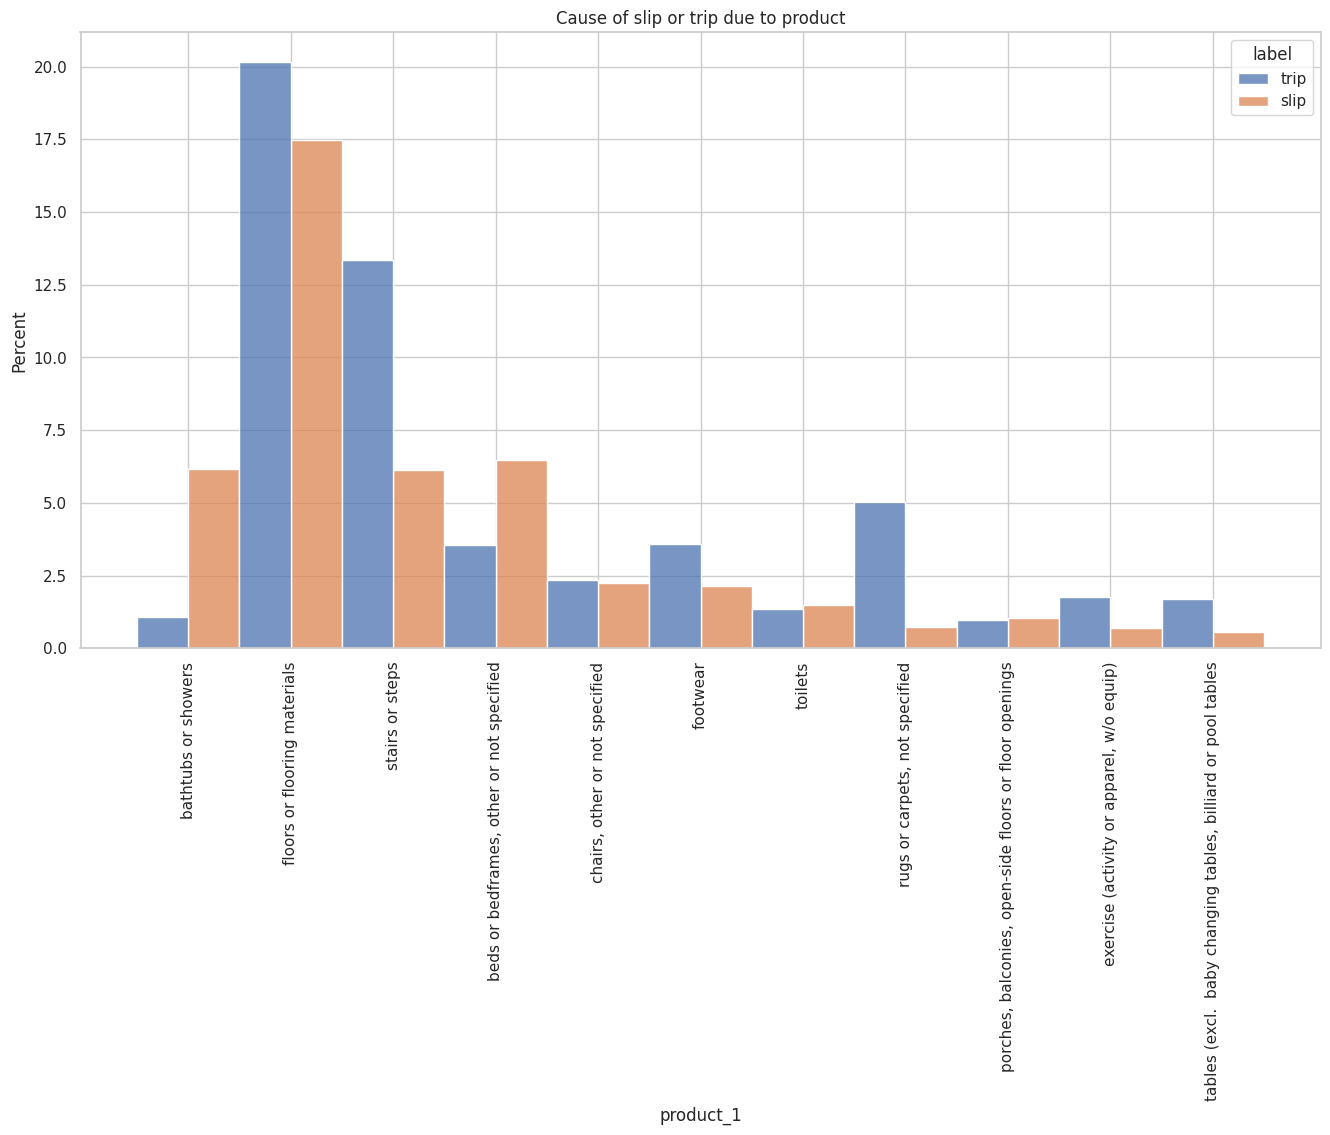

In [50]:
prod_to_consider = list(set(np.concatenate([df_slip.product_1.value_counts().head(8).index, 
                                      df_trip.product_1.value_counts().head(8).index])))
h  = sns.histplot(df_slip_trip[df_slip_trip.product_1.isin(prod_to_consider)], 
           x='product_1', hue='label', stat='percent', multiple='dodge').set(title='Cause of slip or trip due to product')
h = plt.xticks(rotation=90)

Slipping or Tripping in floor are almost equally likely.\
Tripping in rugs or carpet however far exceeds slipping .\
Slipping in bathtubs or shower (wet surface) is far more predominant as expected. 

Test hypothesis:
1. Surface specially in Street are more slippery in winter months causing far more slip events?

count    31.000000
mean      7.161290
std       4.075101
min       1.000000
25%       3.000000
50%       8.000000
75%      11.000000
max      12.000000
Name: month, dtype: float64


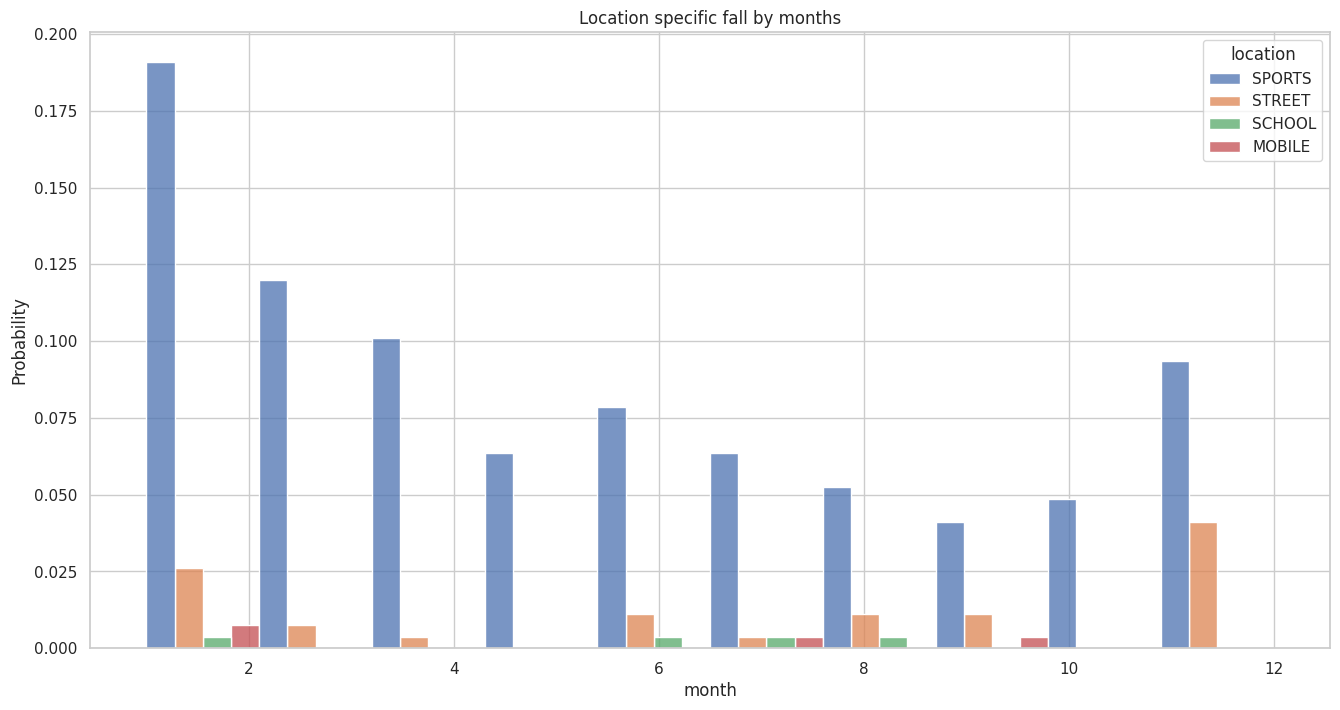

In [51]:
df_slip['treatment_date'] = pd.to_datetime(df_slip['treatment_date'])
df_slip['month'] = df_slip.treatment_date.apply(lambda x: x.month)
df_slip['year'] = df_slip.treatment_date.apply(lambda x: x.year)
print (df_slip[df_slip.location=='STREET'].month.describe())
h  = sns.histplot(df_slip[df_slip.location.isin(['SPORTS','STREET', 'SCHOOL','MOBILE'])], multiple='dodge', stat="probability",
           x='month', hue='location').set(title='Location specific fall by months')

<span style='color:blue'> We observe the increase in slip and fall in the street during winter months. </span>

We can also construct graph(networkx) for data exploration and find fringe cases of interest.

In [52]:
# create the interactive graph using y-files and set scaling 
def make_y_files_graph(G, set_scaling=False):
    w = GraphWidget(graph=G)
    w.set_node_color_mapping('color')
    w.set_graph_layout('organic')
    # the sidebar is set to False but if you would like to interactively explore 
    # you can toggle it with sicon at bottom right
    w.set_sidebar(False) 
    if set_scaling:
        w.set_node_scale_factor_mapping('node_size')
    return w

In [53]:
scale_node = 4 # the scaling is just so that the graph renders in the alloted widget dimension for display
G = nx.Graph()
edges_body_diag =  []
for item in tqdm(df_slip.iterrows(), total=df_slip.shape[0]):
        edges_body_diag.append((item[1].body_part , item[1].diagnosis))
        
G.add_nodes_from(df_slip.body_part.unique(), color='blue')
G.add_nodes_from(df_slip.diagnosis.unique(), color='red')
G.add_edges_from(edges_body_diag)
#We map the node_size based on degree
for item  in nx.degree(G):
    G.nodes[item[0]]['node_size']=item[1]/scale_node
w = make_y_files_graph(G, set_scaling=True)       

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14333/14333 [00:00<00:00, 21584.61it/s]


We show a crop from the actual graph as the cell below (w.show()) needs to be run for graph rendering.

Graph depicting relation of body to diagnosis, with node scale mapping  set by node degree
![body_diag_graph](images/slip_internal_injury.png)

** Best visualized in fullscreen after rendering(run the cell below)

In [54]:
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

As mentioned in introduction we test the hypothesis that 'Slipped' could lead to more back of the head injuries while 'Tripped' would cause more frontal injuries such as faces due to involutary forwad motion.


In [55]:
print ('For slip related event degree of internal injury=', G.degree('internal injury'))
print ('which means theres are only 3 body part related to internal injury when slip occurs')
slip_body_value_count = df_slip[df_slip.diagnosis=='internal injury'].body_part.value_counts(normalize=True).to_dict()
print ()
print (slip_body_value_count)
s_head = slip_body_value_count['head']
print (f'So injury to the head accounts for {s_head*100} % of internal injury')


For slip related event degree of internal injury= 3
which means theres are only 3 body part related to internal injury when slip occurs

{'head': 0.989883022447044, 'upper trunk': 0.0094846664558963, 'lower trunk': 0.0006323110970597534}
So injury to the head accounts for 98.9883022447044 % of internal injury


In [56]:
print ('For tripped event')
print (df_trip.body_part.value_counts(normalize=True).head(5))
print ()
print ('For slipped event')
print (df_slip.body_part.value_counts(normalize=True).head(5))

For tripped event
body_part
head           0.429916
face           0.118934
lower trunk    0.112224
upper trunk    0.053233
knee           0.045771
Name: proportion, dtype: float64

For slipped event
body_part
head           0.290518
lower trunk    0.232750
upper trunk    0.060280
face           0.058536
knee           0.051908
Name: proportion, dtype: float64


In [57]:
# cheak multiple occurences of body_part injuries
def cheak_multiple_occurences(dfc, col1, col2,  part1, part2):
    dtemp_1 = dfc[(dfc[col1].isin([part1, part2]))]
    dtemp_2 = dtemp_1[(dtemp_1[col2].isin([part1, part2]))]
    print (dtemp_2.shape[0]/dfc.shape[0]*100, '%')

In [58]:
print ('occurences of head and face injury when slip event happens')
cheak_multiple_occurences(df_slip, 'body_part', 'body_part_2',  'head', 'face')

occurences of head and face injury when slip event happens
6.628061117700412 %


In [59]:
print ('occurences of head and face injury when trip event happens')
cheak_multiple_occurences(df_trip, 'body_part', 'body_part_2',  'head', 'face')

occurences of head and face injury when trip event happens
11.442736241173819 %


So we conclude that in tripped event, injury to the face is twice as higher than when slipping occurs.
But in both slipping and tripping head injury is the most a body_part is affected, 
We can not know which part of the head unless the narrative mentions this, though it 
would not be unreasonable to assume that a slip can cause injuries to the back.

Lets us explore fall caused due to <span style='color:brown'>dizzyness</span>, which can occur without involvement of external factors.

0 dizzy
Getting embeddings from OpenAI
(1, 1536)
{'dizzy': 'dizzy'}
(2915, 23) (115128, 23)
(2915, 25)
label
dizzy    2915
Name: count, dtype: int64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2915/2915 [00:00<00:00, 6673.32it/s]


<Axes: xlabel='diagnosis', ylabel='body_part'>

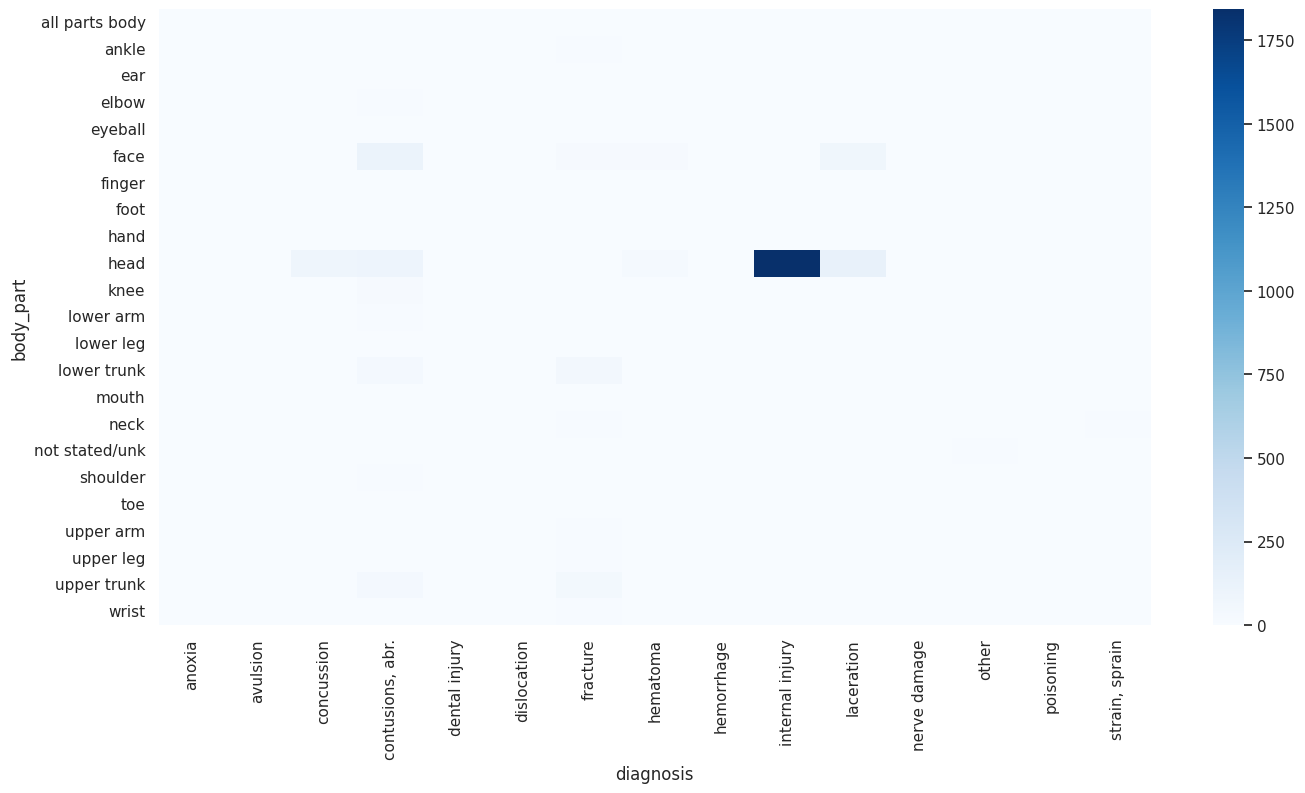

In [60]:
# lets look at what happens when falling due to dizzyness
query_dizzy = {'dizzy': 'dizzy'}
df_dizzy = get_query_results(query_dizzy, thres=0.37, file_name='')
co_occurrence_matrix_dizzy  = pd.crosstab(df_dizzy['body_part'], df_dizzy['diagnosis'])
sns.heatmap(co_occurrence_matrix_dizzy, cmap='Blues')

<span style='color:blue'> Similar to slipping, fall due to dizzyness also involves high count of internal injury to the head.
Doing semantic search with dizzy also captures  "OFF BALANCE" as dizzy, 
whereas simple keyword search would not have made this association. </span> 

<span style='color:brown'>Excercise: </span> 

In [61]:
activities = [v for v in mapping['product_1'].values() if 'activity' in v.lower()]
print ('num activities:', len(activities))
for i, v in enumerate(activities):
    print (v)
    if i==5:
        break

num activities: 81
1200 - SPORTS AND RECREATIONAL ACTIVITY, N.E.C.
1204 - BASEBALL, ACTIVITY AND RELATED EQUIPMENT
1205 - BASKETBALL, ACTIVITY AND RELATED EQUIPMENT
1206 - BOWLING (ACTIVITY, APPAREL OR EQUIPMENT)
1207 - BOXING (ACTIVITY, APPAREL OR EQUIPMENT)
1208 - CROQUET (ACTIVITY, APPAREL OR EQUIPMENT)


Although 81 exercise activities are explicitly given in product, we will do semantic search that encompasses them all (including dancing) 

0 exercising dancing
Getting embeddings from OpenAI
(1, 1536)
{'excersize': 'exercising dancing'}
(312, 23) (115128, 23)
(312, 25)
label
excersize    312
Name: count, dtype: int64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 6973.89it/s]


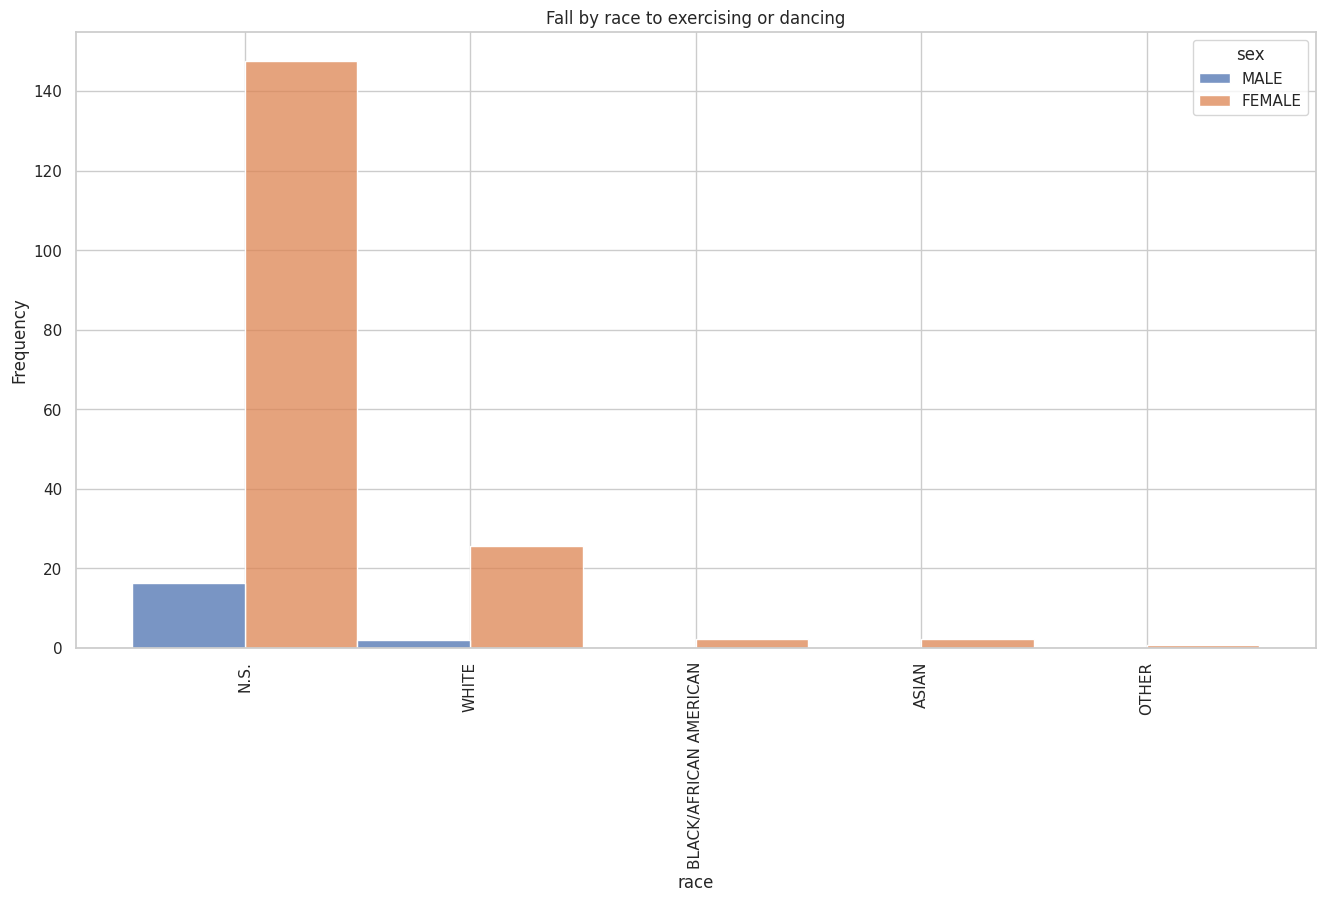

In [62]:
query_ex = {'excersize': 'exercising dancing'}
df_exer = get_query_results(query_ex, thres=0.42, file_name='')
h = sns.histplot(df_exer, x='race',  stat = 'frequency', hue='sex', multiple='dodge').set(
    title='Fall by race to exercising or dancing')
h = plt.xticks(rotation=90)

<span style='color:blue'> White Female exercise and fall the most when race is given.</span>

<span style='color:brown'> A semantic query that has body_part and product both as context could be done as follows: </span>

In [63]:
# here 'hit' and 'getting out' are the action, 'wall' and 'chair' are the product ,
# 'head' and 'leg' are the body_part respectively
groups_hit = {'wall' : 'hit wall head', 'getup': 'getting out chair ankle leg'}
remove_to_clean = ['location'] # we only remove location and not the body part as it constitutes the query
df_body = get_query_results(groups_hit, thres=0.37, remove_to_clean=remove_to_clean, file_name='')
show_samples(df_body)

0 hit wall head
1 getting out chair ankle leg
Getting embeddings from OpenAI
(2, 1536)
{'wall': 'hit wall head', 'getup': 'getting out chair ankle leg'}
(5388, 24) (115128, 24)
(5388, 26)
label
getup    2803
wall     2585
Name: count, dtype: int64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5388/5388 [00:01<00:00, 4709.72it/s]


Batches:   0%|          | 0/169 [00:00<?, ?it/s]

===> Finding 1500 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 6.54 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.27 seconds
===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
(5388, 2) (5388,)
silhouette_score = 0.29176939990313056
calinski_harabasz_score = 2438.831821810288
narrative -> 76 YOF FELL BACKWARDS ON STAIRS HITTING THE BACK OF HER HEAD ON WALL.DX: TRAUMATIC INJURY OF HEAD
clean text-> fell backwards on stairs hitting back of head on wall -> wall
____________________________________________________________________
narrative -> 66YOF.GETTING OUT OF BED SLIPPED.FELL DOWN..DX.CONT.BACK.AND.LT/RT/KNEE
clean text-> slipped and fell due to beds or bedframes, other or not specified -> getup
____________________________________________________________________
narrative 

[Text(0.5, 1.0, 'Cluster comaprision between hitting wall with head and getting up hurting leg')]

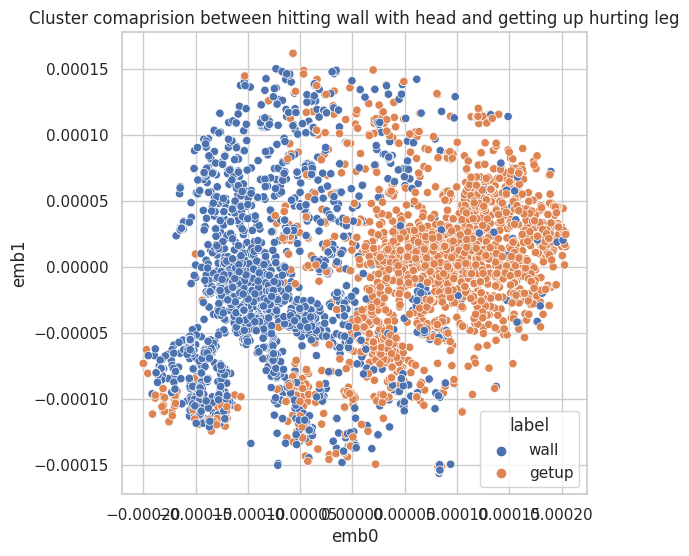

In [64]:
sns.set(style="whitegrid", rc={'figure.figsize':(6, 6)})
sns.scatterplot(data=df_body, x='emb0', y='emb1', hue='label').set(title='Cluster comaprision between hitting wall \
with head and getting up hurting leg')

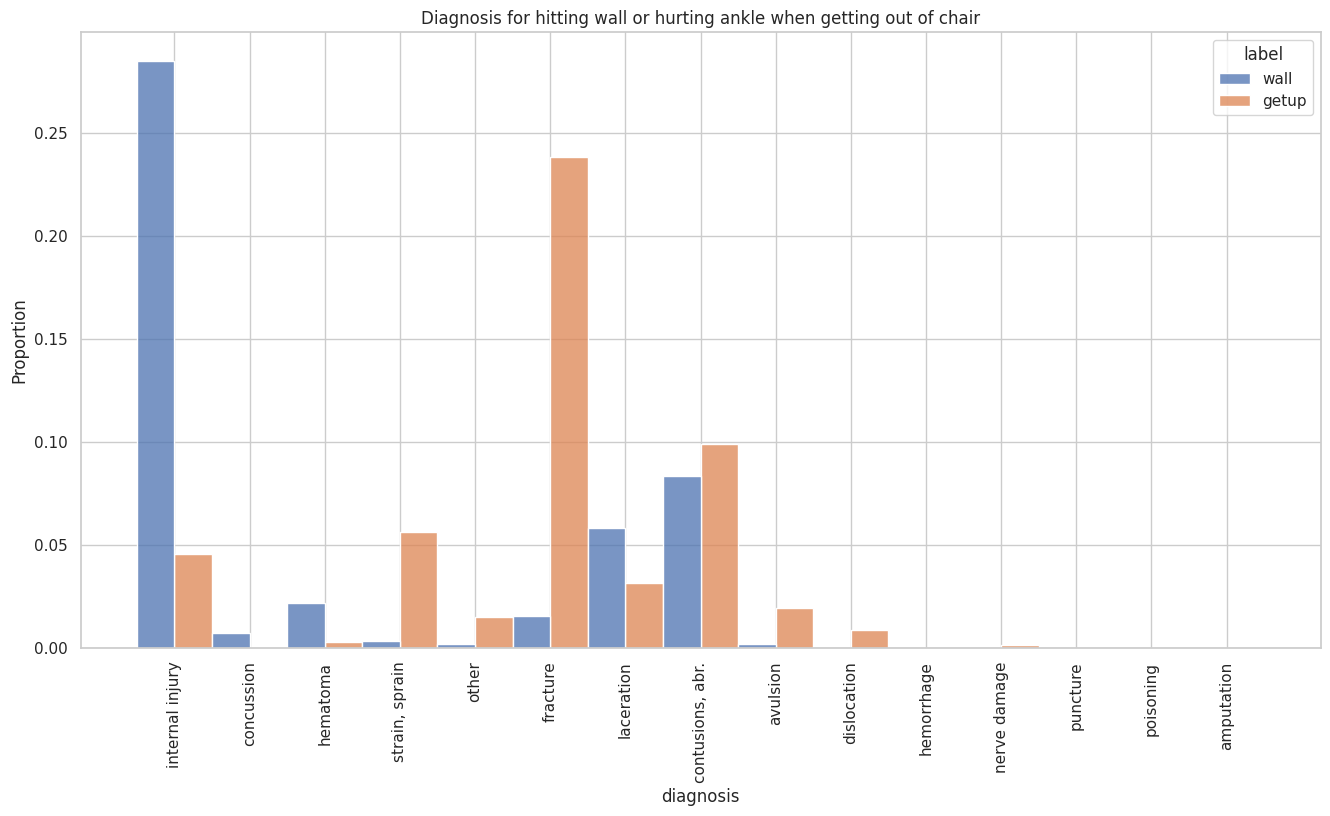

In [65]:
sns.set(style="whitegrid", rc={'figure.figsize':(16, 8)})

g = sns.histplot(data=df_body,  x='diagnosis', stat = 'proportion', hue='label', multiple='dodge').set(
    title='Diagnosis for hitting wall or hurting ankle when getting out of chair')
g = plt.xticks(rotation=90)

<span style='color:blue'> Hitting the wall with head results in internal injuries the most while fracture is more common when getting up from chair with leg injuries</span>

<span style='color:brown'>We look at alcohol drug contribution to fall (on the full primary dataset) for each location </span>

In [66]:
G = nx.Graph()
edges_ad = []
for item in df.iterrows():
    if item[1].alcohol=='Yes':
        edges_ad.append(('alcohol', item[1].location))
    if item[1].drug=='Yes':
        edges_ad.append(('drug', item[1].location))
        
G.add_nodes_from(['alcohol', 'drug'], color='red', node_size=1)
G.add_nodes_from(df.location.unique().tolist(), color='yellow')

G.add_edges_from(edges_ad)
w = make_y_files_graph(G, set_scaling=False) 

<span style="color:red"> Graph depicting alcohol and drug contribution in fall at given locations
![alcohol_drug](images/g_alcohol_drug.png) </span>

** we show the graph as markdown image saved beforehand as for full interactive rendering of the graph the
code below needs to be executed. For best visualization open in full screen (toggle in sidebar).

In [67]:
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

<span style="color:blue">We see that in FARM AND INDST drug and alcohol are never involved. 
Yet surprisingly drug being involved in school, and alcohol is not.</span>

<span style='color:brown'> Sometimes multiple diagnosis are made, so lets look at those.</span>

In [68]:
def get_nodes_edges_multiple(df, nodes_columns=['diagnosis', 'diagnosis_2']):
    edges_between_diag = []
    for item in df[nodes_columns].iterrows():
        item = item[1].values
        if isinstance(item[0], str) and isinstance(item[1], str):
            edges_between_diag.append(tuple(item))
    nodes = df[nodes_columns[0]].unique()
    return nodes  , edges_between_diag

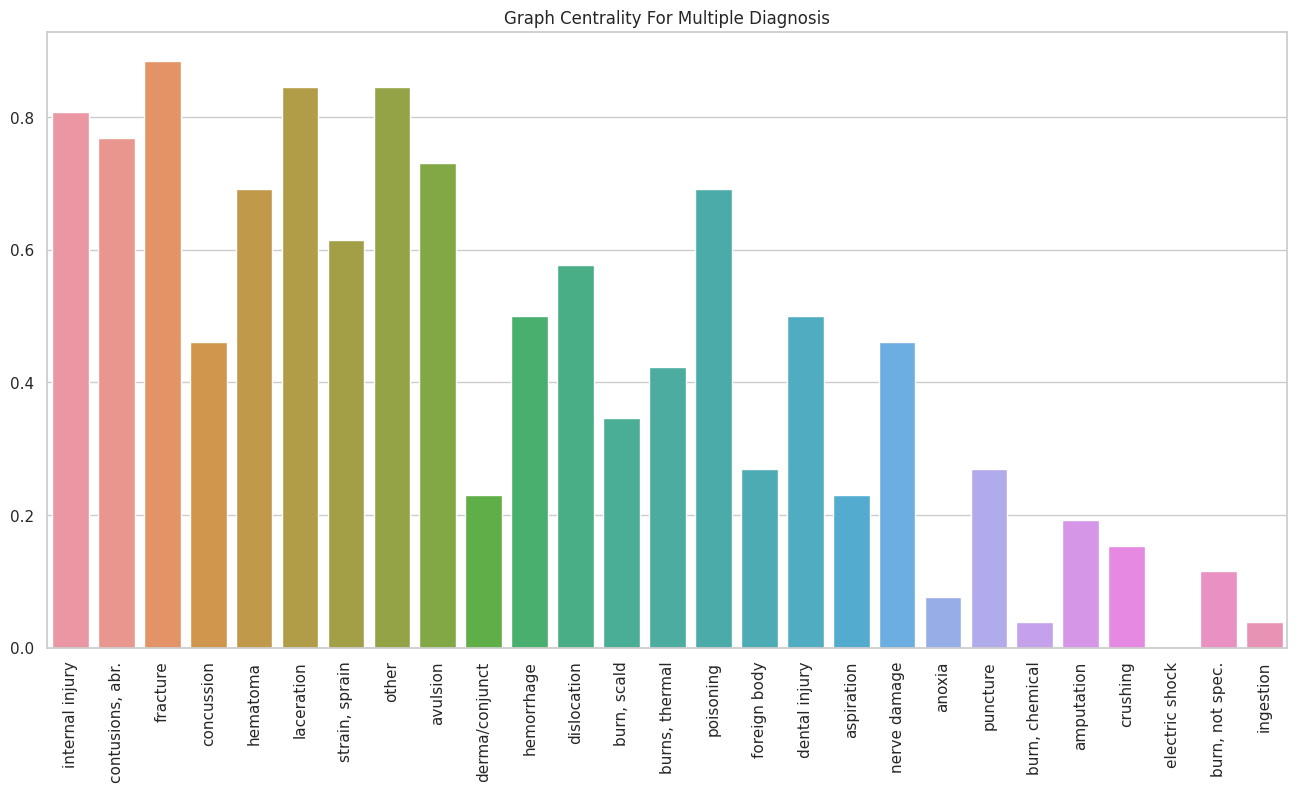

In [69]:
G = nx.Graph()
n, e = get_nodes_edges_multiple(df, nodes_columns=['diagnosis', 'diagnosis_2'])
G.add_nodes_from(n)
G.add_edges_from(e)
# We take each nodes centrality
centrality_daig = nx.degree_centrality(G)
h = sns.barplot(x=list(centrality_daig.keys()), y=list(centrality_daig.values())).set(title='Graph Centrality For Multiple Diagnosis')
h = plt.xticks(rotation=90)

In [70]:
print (f'Num samples for fracture = {df.diagnosis.value_counts().fracture}')
print (f'Num samples for poisoning = {df.diagnosis.value_counts().poisoning}')

Num samples for fracture = 37125
Num samples for poisoning = 350


<span style='color:blue'> We see fracture to have the highest centrality , i.e more injuries can be present when we have fracture  and although there are relatively few samples for poisoning we also see a high centrality, which means it is often accompanied by other injuries</span>

We can create simple knowledge graphs to help us visualize the interaction between different columns easier. It allowed us
to explore fringe cases far more effectively. For these demonstration we make the graph small by subsetting to categories with few samples such as: how are the other column details such as location, body part, sex etc interact when we pick only diagnosis assigned to nerve damage.

In [71]:
#df_do = df[df.diagnosis=='poisoning']
#df_do = df[df.disposition=='held for observation']

df_do = df[df.diagnosis=='nerve damage']
#print (df_do.shape)
colors=['blue', 'red', 'green', 'yellow', 'purple']
G = nx.DiGraph()
G.add_nodes_from(list(mapping['location'].values()), color='yellow')
G.add_nodes_from(df.body_part.unique().tolist(), color='red')
G.add_nodes_from(list(mapping['race'].values()), color='green')
G.add_nodes_from(list(mapping['sex'].values()), color='purple')

edges_location_body =  []
for item in tqdm(df_do.iterrows(), total=df_do.shape[0]):
        edges_location_body.append((item[1].location , item[1].body_part))
        
edges_race_sex =  []
for item in tqdm(df_do.iterrows(), total=df_do.shape[0]):
        edges_race_sex.append((item[1].race , item[1].sex))

edges_sex_location =  []
for item in tqdm(df_do.iterrows(), total=df_do.shape[0]):
        edges_sex_location.append((item[1].sex , item[1].location))

G.add_edges_from(edges_location_body, relation='in')
G.add_edges_from(edges_race_sex, relation='belongs')
G.add_edges_from(edges_sex_location, relation='sex')

# we use degree of a node to scale the nodes
# here we clip the node size as there are isolated nodes whose degree are 0
# which y-files had difficulty rendering 
for item  in nx.degree(G):
    print (item)
    G.nodes[item[0]]['node_size']=np.clip(item[1]/6, 0.05, 4)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 21454.24it/s]

('UNK', 9)
('HOME', 14)
('FARM', 0)
('APART.', 0)
('STREET', 0)
('PUBLIC', 6)
('MOBILE', 0)
('INDST.', 0)
('SCHOOL', 0)
('SPORTS', 4)
('head', 2)
('elbow', 0)
('lower arm', 2)
('shoulder', 2)
('face', 0)
('lower trunk', 4)
('wrist', 1)
('ankle', 0)
('upper leg', 0)
('knee', 1)
('upper trunk', 3)
('foot', 1)
('upper arm', 1)
('lower leg', 2)
('mouth', 0)
('hand', 0)
('finger', 0)
('neck', 4)
('toe', 0)
('not stated/unk', 1)
('all parts body', 0)
('ear', 0)
('pubic region', 0)
('eyeball', 1)
('internal', 0)
('N.S.', 2)
('WHITE', 2)
('BLACK/AFRICAN AMERICAN', 2)
('OTHER', 1)
('ASIAN', 2)
('AMERICAN INDIAN/ALASKA NATIVE', 0)
('NATIVE HAWAIIAN/PACIFIC ISLANDER', 0)
('UNKNOWN', 0)
('MALE', 9)
('FEMALE', 8)
('NON-BINARY/OTHER', 0)


![nerve damage](images/graph_nerve_damage.png)

In [72]:
w = make_y_files_graph(G, set_scaling=True)
w.set_edge_label_mapping('relation')

In [73]:
w.show()

GraphWidget(layout=Layout(height='500px', width='100%'))

It seems neck injury causes nerve damage; more so than the dataset's general distribution. Many locations such as MOBILE, STREET, FARM have not reported this type of incident. Many of the body part are not affected by this injury as shown by isolated nodes in the graph. Male and Female are equally likely to be affected.